Machine Learning aplicado a la predicción de precio de criptomonedas, utilizando valores anteriores de las principales critpomonedas, valores de índices de stocks, y trends de búsqueda. 

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt # Plots
import matplotlib.gridspec as gridspec
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# Keras
import time
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt

#Manejo de archivos
import os
import tempfile
import shutil

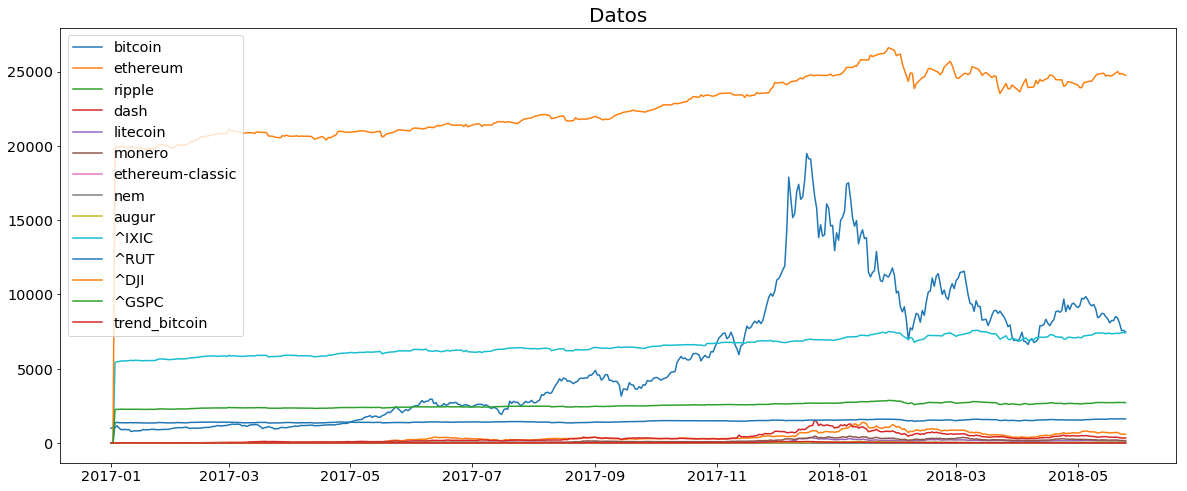

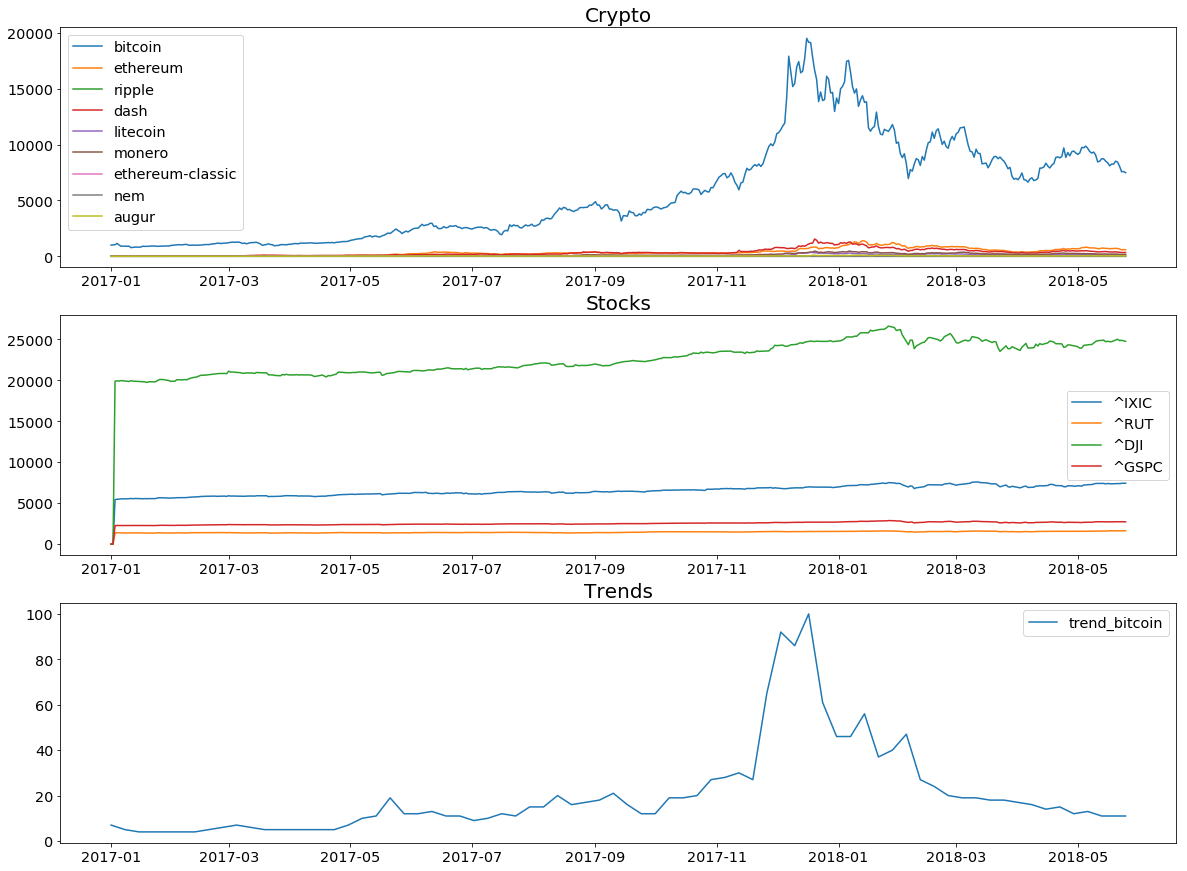

In [7]:
criptomonedas_posibles = ['bitcoin','ethereum','ripple','dash','litecoin',
                     'monero','ethereum-classic','nem','augur',                 
                     'litecoin','cardano','stellar','iota','tron',
                     'neo','dash','bitcoin-cash','eos','vechain',
                     'tether','qtum','omisego','icon','binance-coin',
                     'lisk','bitcoin-gold','bytecoin-bcn','nano','verge',
                     'zcash','aeternity','zilliqa']
top_criptomonedas = ['bitcoin','ethereum','ripple','dash','litecoin','monero','ethereum-classic','nem','augur']
stocks_names=['AAPL','FB','GOOG','GOOGL','IBM','INTC','MSFT','NFLX','ORCL','TSLA']
stockindex_names=['^IXIC','^RUT','^DJI','^GSPC']

targets_crypto = top_criptomonedas
targets_stocks = ['^IXIC','^RUT','^DJI','^GSPC']
targets_trends = ['bitcoin']

data = pd.read_csv('data/data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

#Graficar la serie completa
plt.figure(figsize=(20,8))
for i in range(0,len(data.columns)):
    plt.plot(data.index, data[data.columns[i]], label=data.columns[i])
plt.legend(loc='upper left')
plt.title("Datos",fontsize=20)
#plt.savefig('baselines/naive_seriecompleta.png')
plt.show()

#Graficar la serie completa
plt.figure(figsize=(20,15))
plt.subplot(3, 1, 1)
for i in range(0,len(targets_crypto)):
    plt.plot(data.index, data[data.columns[i]], label=data.columns[i])
    plt.legend(loc='best')
    plt.title("Crypto",fontsize=20)
plt.subplot(3, 1, 2)
for i in range(len(targets_crypto),len(targets_crypto)+len(targets_stocks)):
    plt.plot(data.index, data[data.columns[i]], label=data.columns[i])
    plt.legend(loc='best')
    plt.title("Stocks",fontsize=20)
plt.subplot(3, 1, 3)
for i in range(len(targets_crypto)+len(targets_stocks),len(data.columns)):
    plt.plot(data.index, data[data.columns[i]], label=data.columns[i])
    plt.legend(loc='best')
    plt.title("Trends",fontsize=20)
#plt.savefig('baselines/naive_seriecompleta.png')
plt.show()

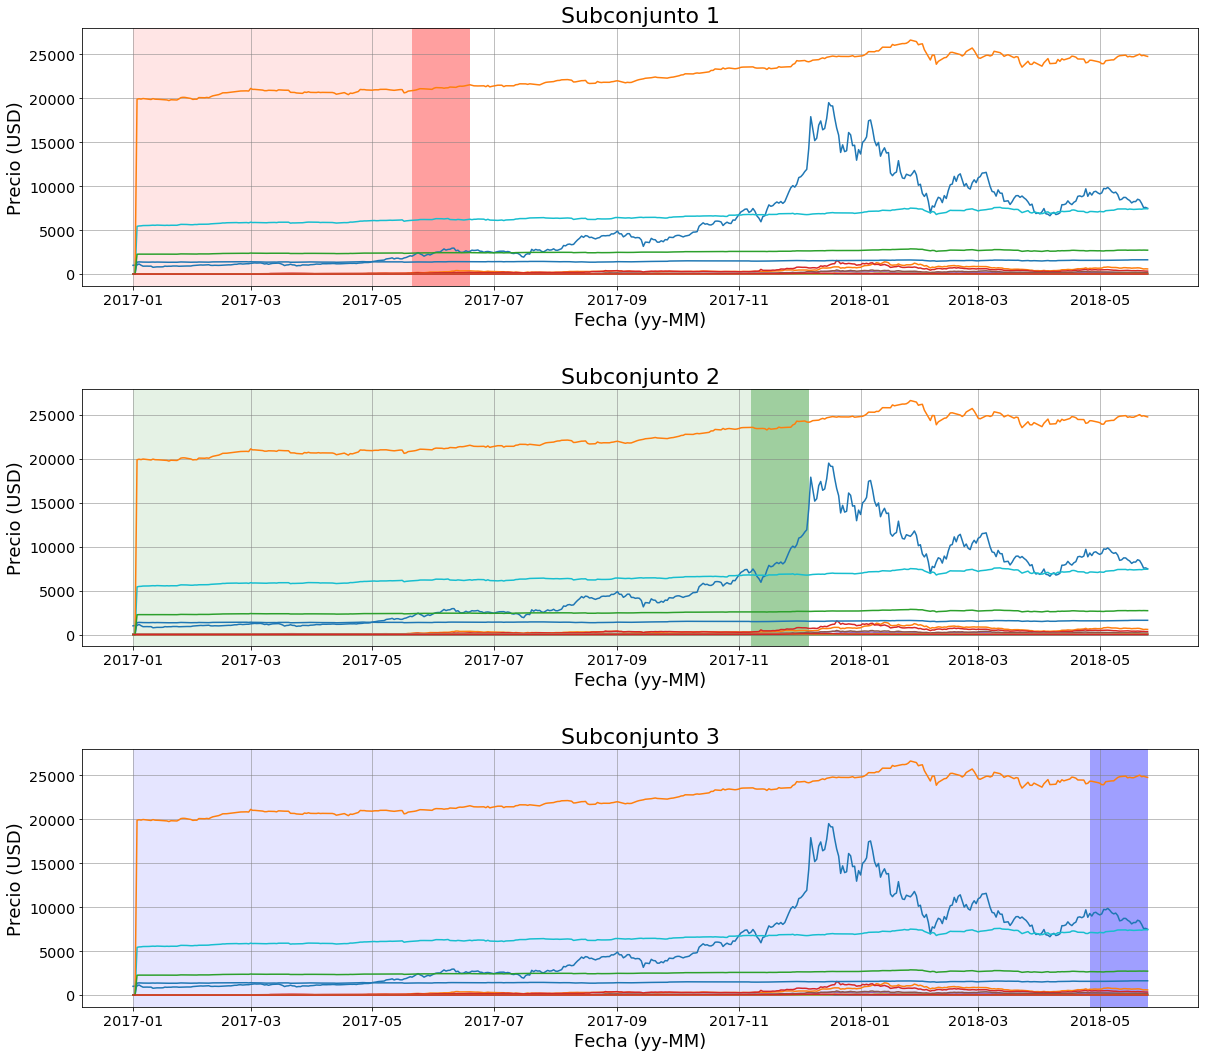

In [8]:
#Simulaciones
test_size = 30
ventana = [1,2]
neuronas = [4]
epochs = [30]
futuro = [1,2,5,7]
moneda = 'bitcoin'
N_tests = 3 #Cuantos tests se van a hacer con la serie
colores_test = ['r','g','b']
colores_futuro = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


#Visualización de resultados
fig = plt.figure(figsize=(20,6*N_tests))
gs = gridspec.GridSpec(N_tests, 1, wspace=0, hspace=0.4)
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    start_test = end-test_size
    subprediccion = data[0:end]
    subprediccion_test = data[start_test:end]    
    ax = plt.subplot(gs[n_test, 0:])
    ax.plot(data.index, data)  
    plt.axvspan(subprediccion.index[0], subprediccion.index[-1], facecolor=colores_test[n_test], alpha=0.1)
    plt.axvspan(subprediccion_test.index[0], subprediccion_test.index[-1], facecolor=colores_test[n_test], alpha=0.3)
    plt.xlabel('Fecha (yy-MM)', fontsize=18)
    plt.ylabel('Precio (USD)', fontsize=18)
    #plt.legend(loc='upper left', labels=data.columns)
    plt.title("Subconjunto " + str(n_test+1),fontsize=22)
    plt.grid(color='grey', linestyle='-', linewidth=0.5)

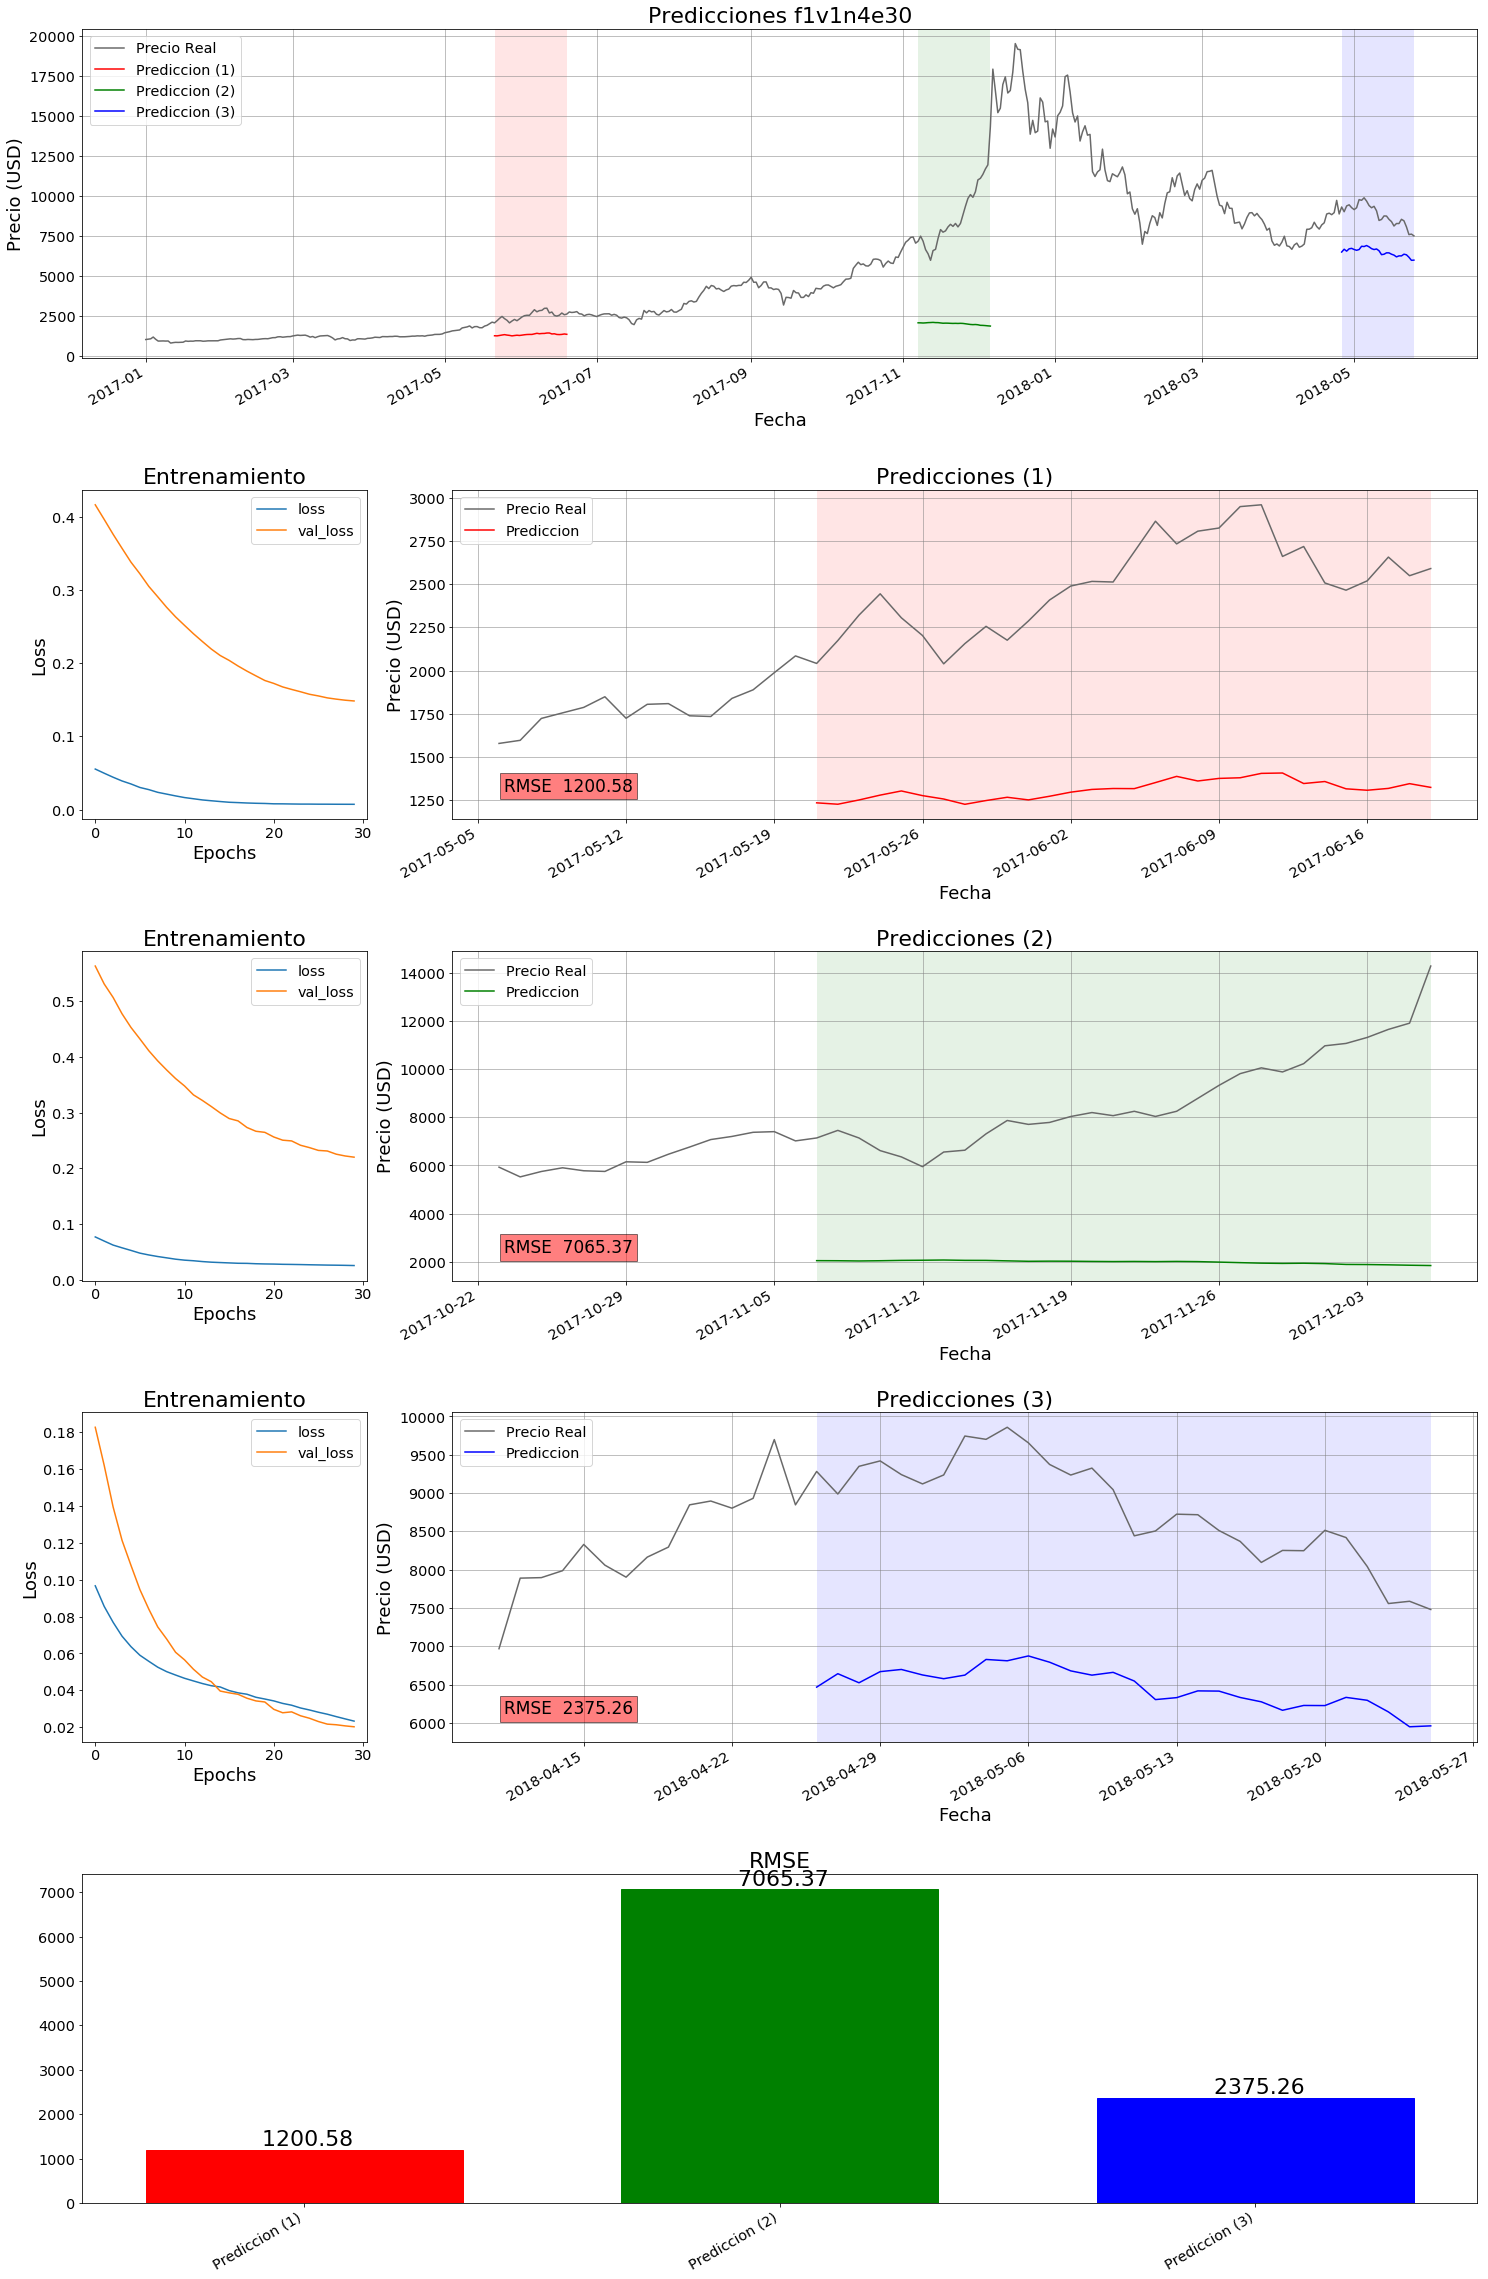

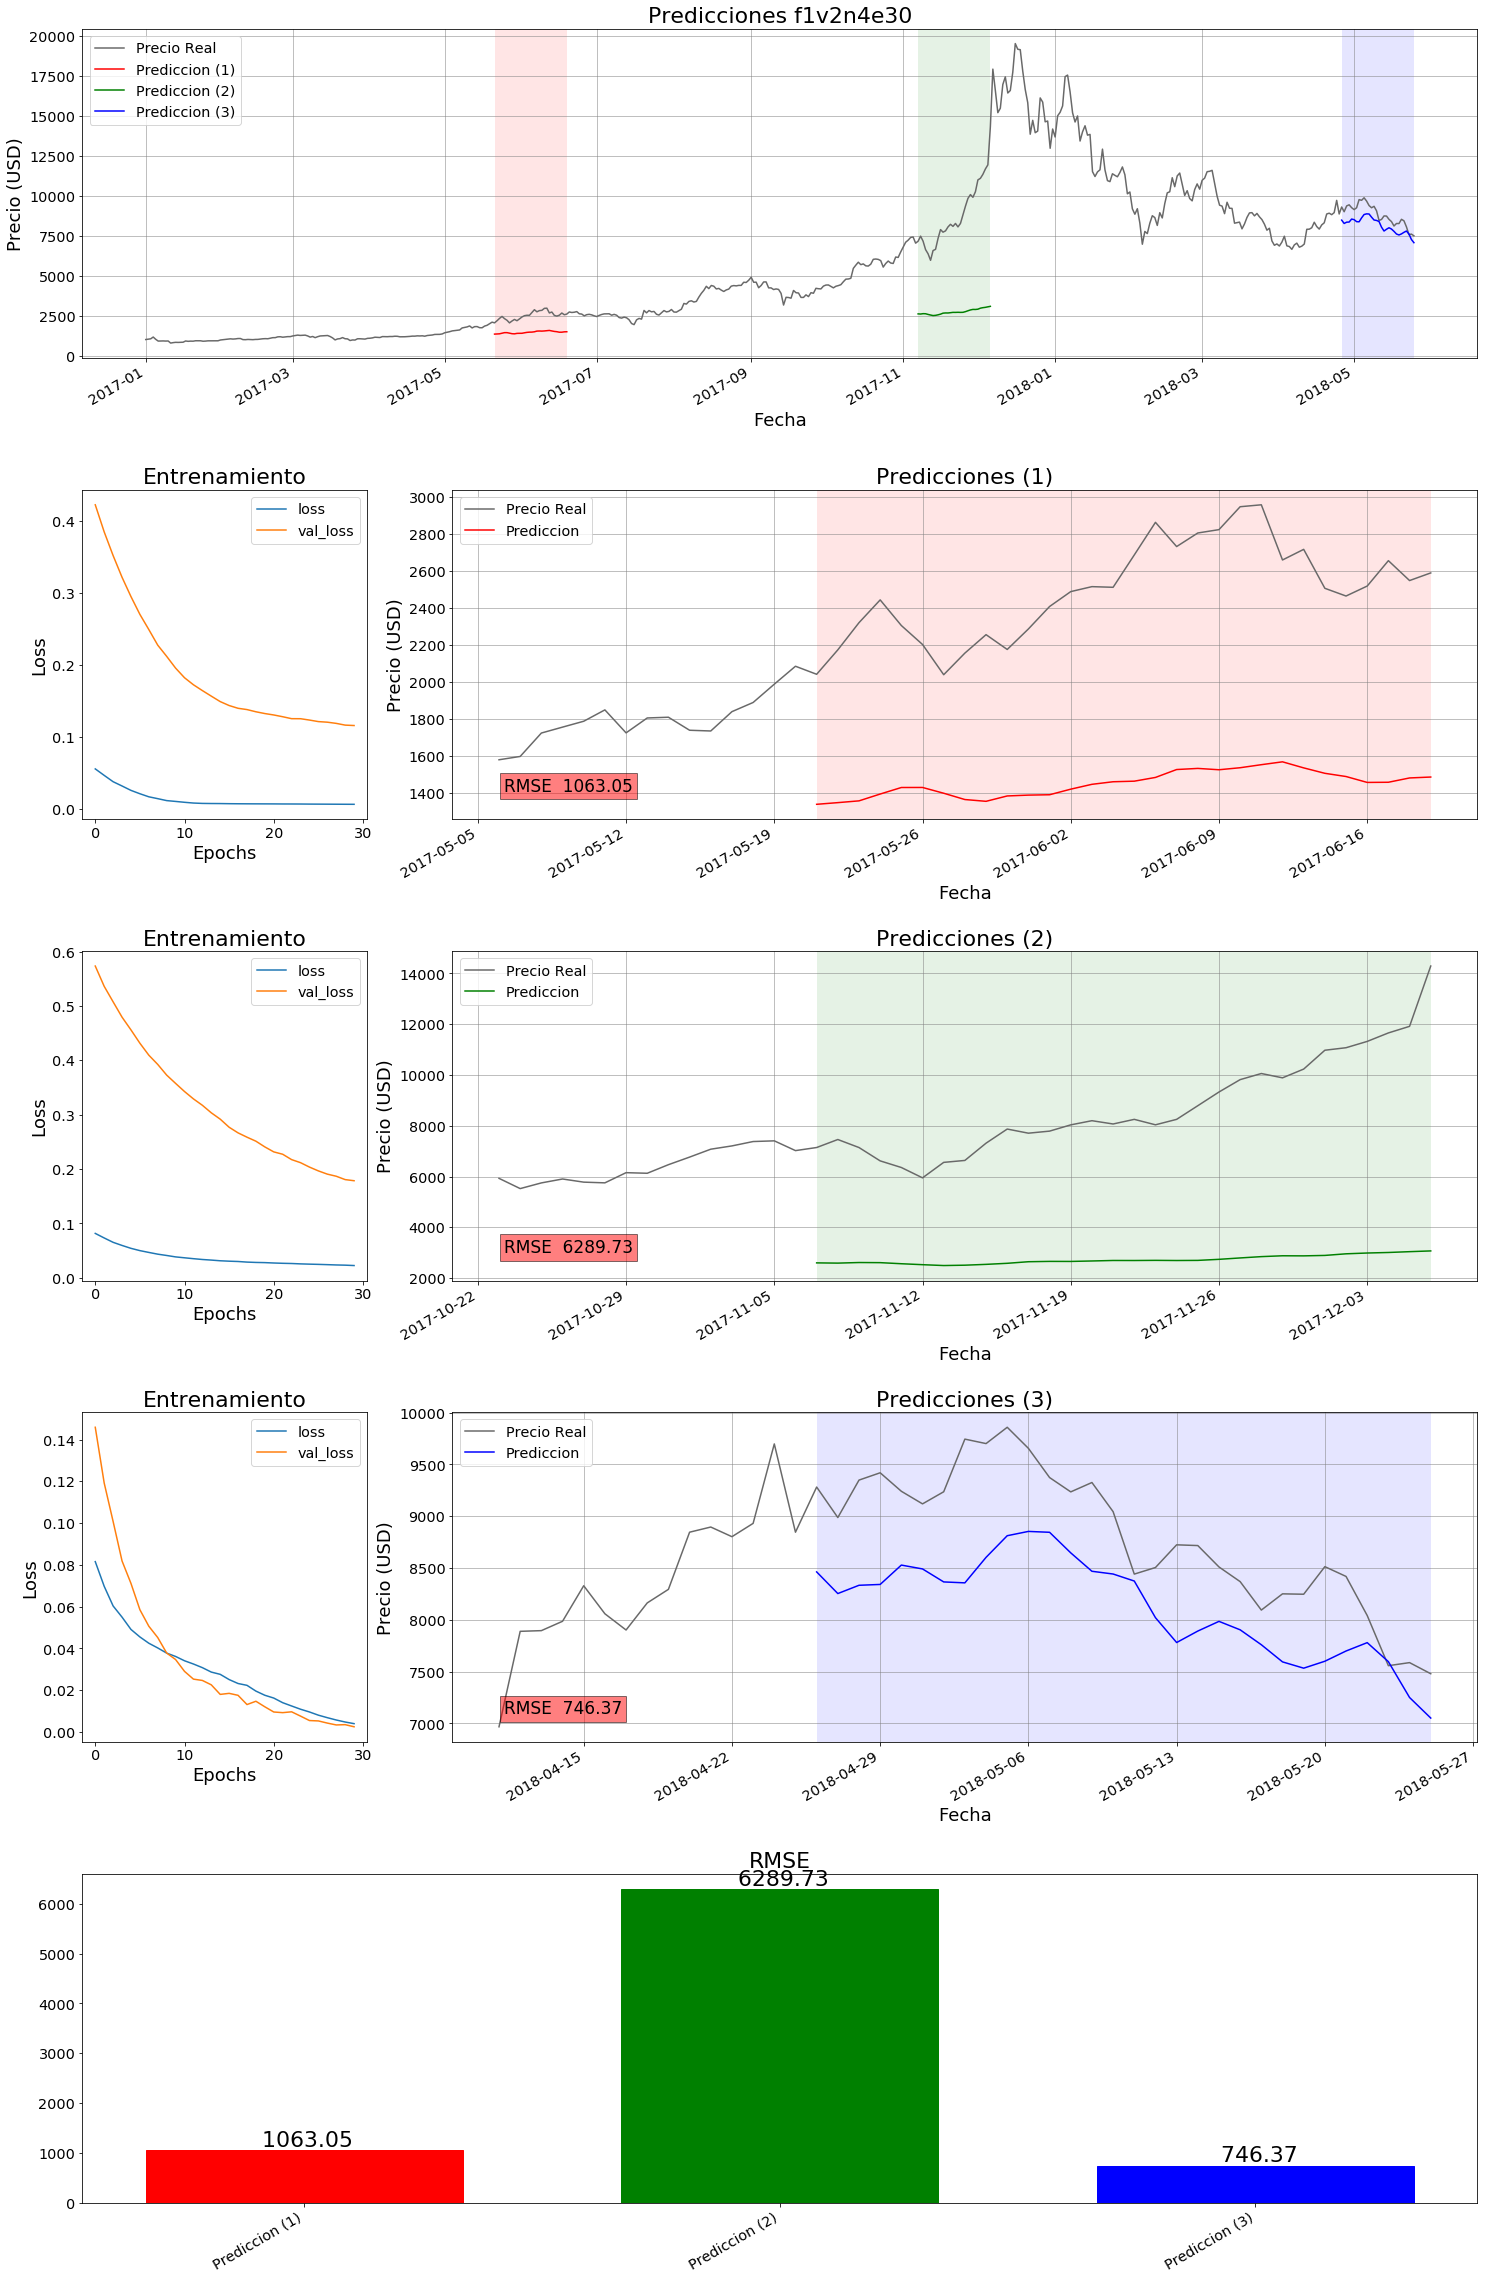

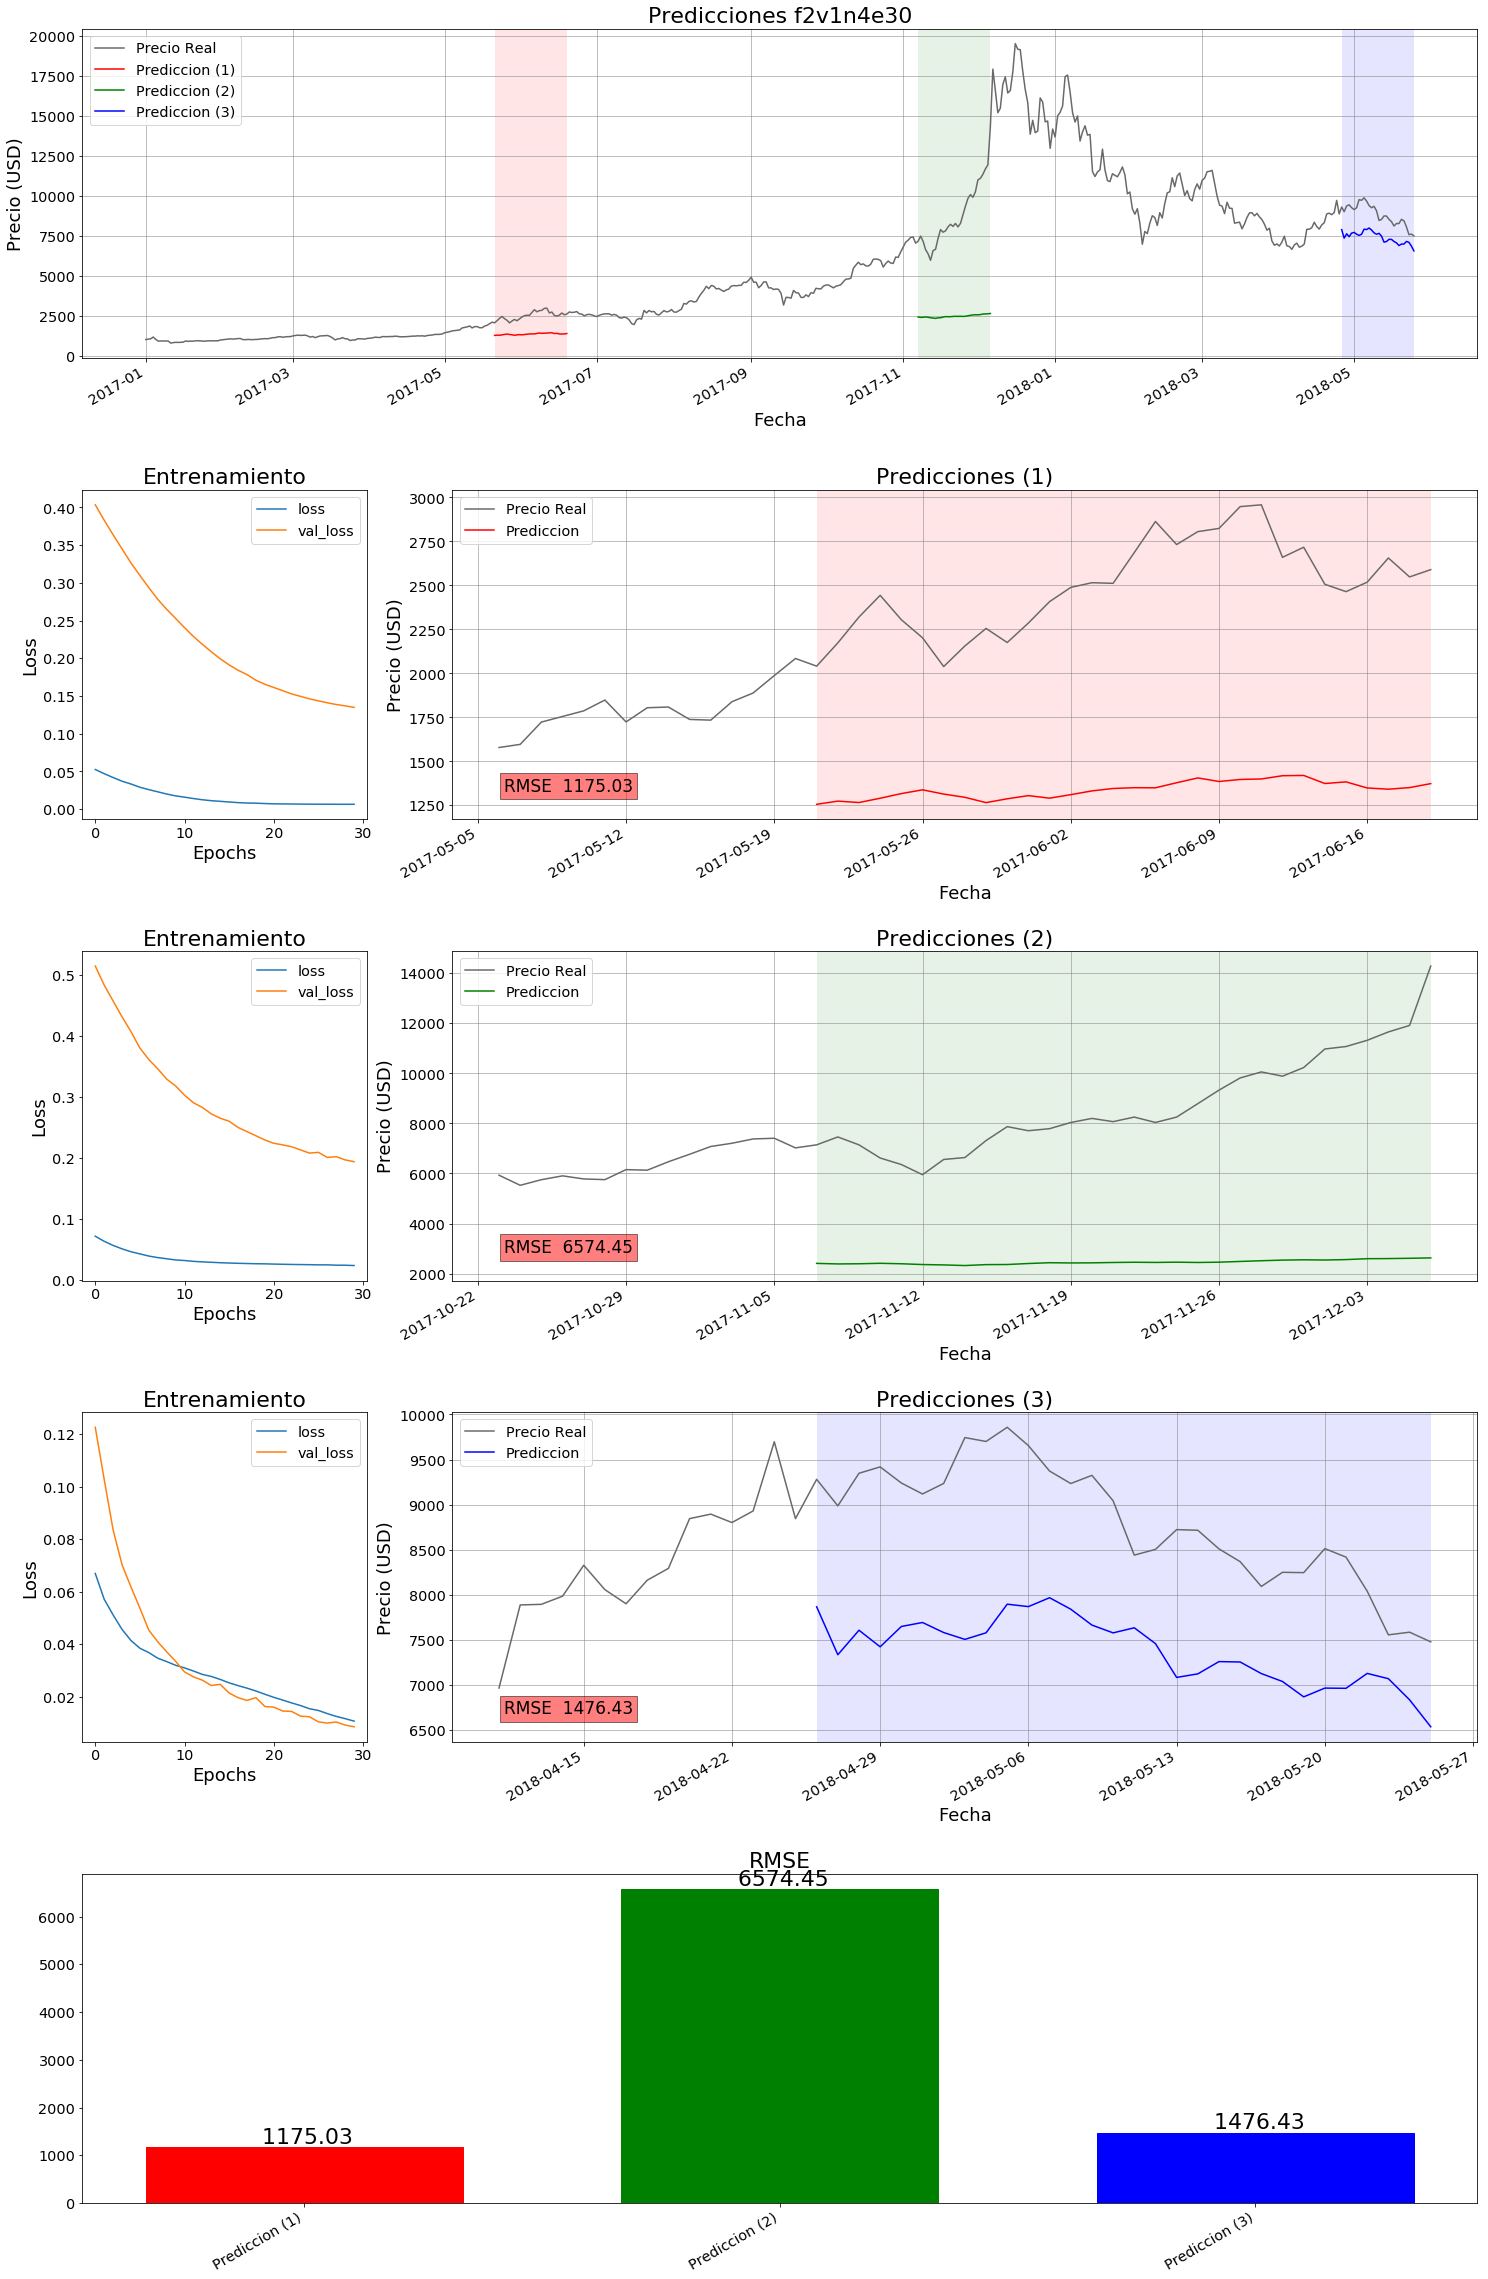

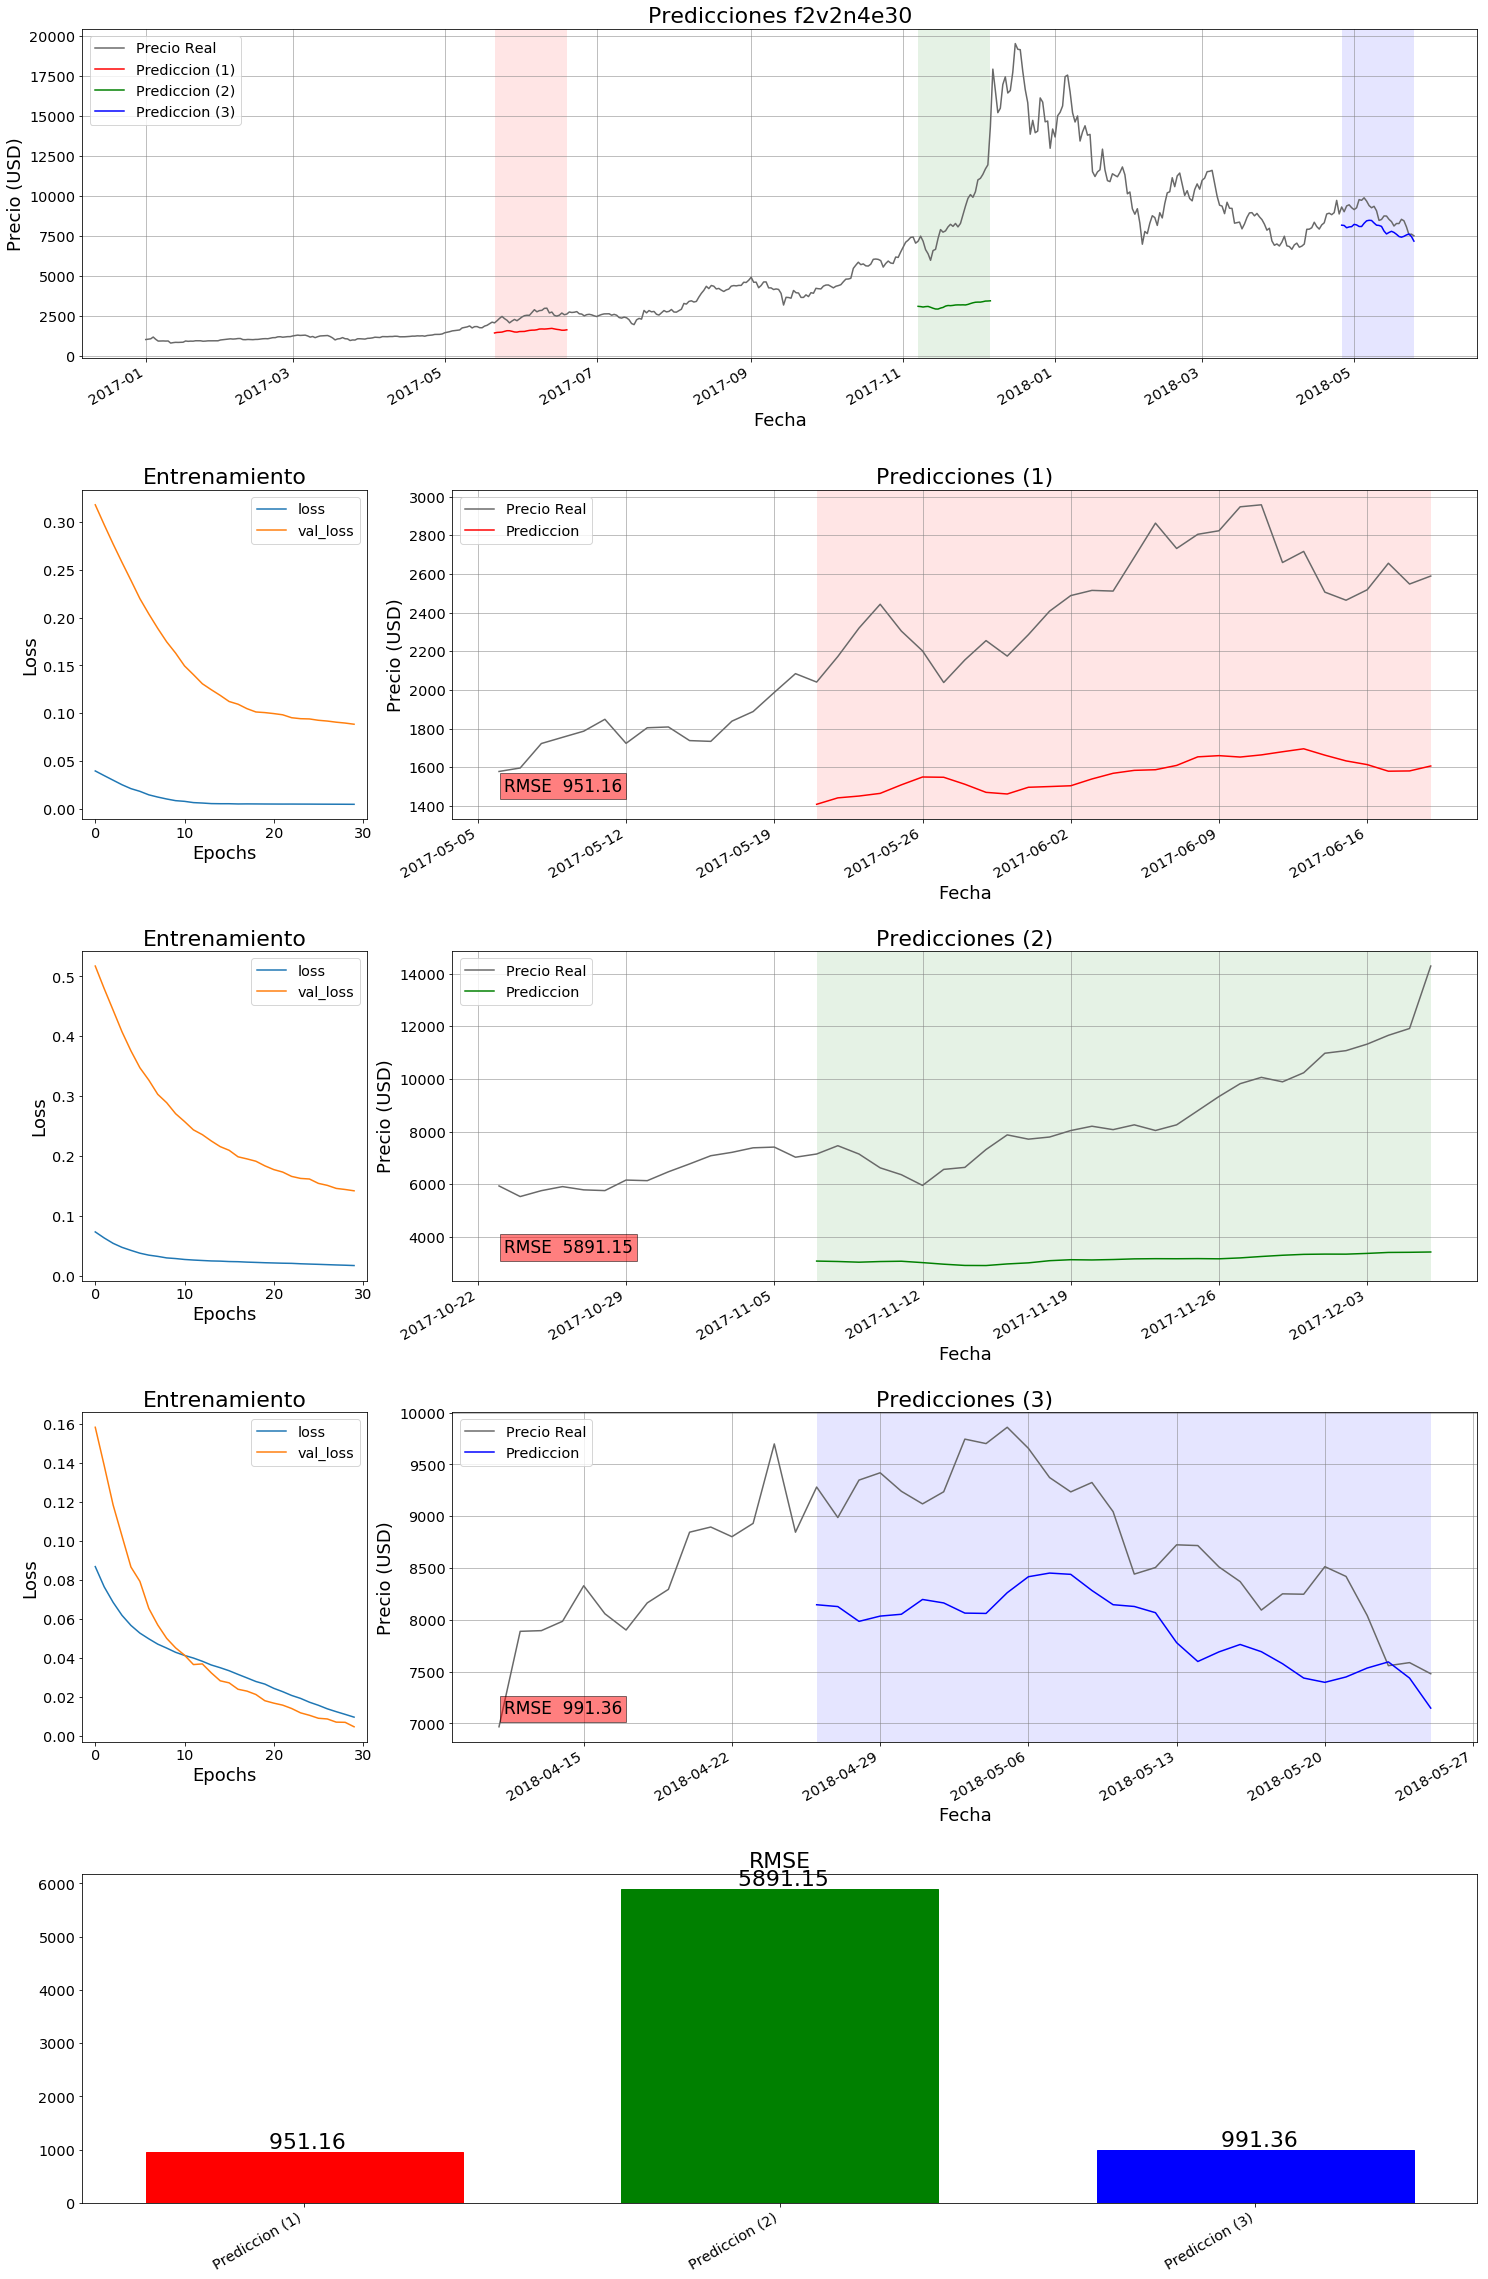

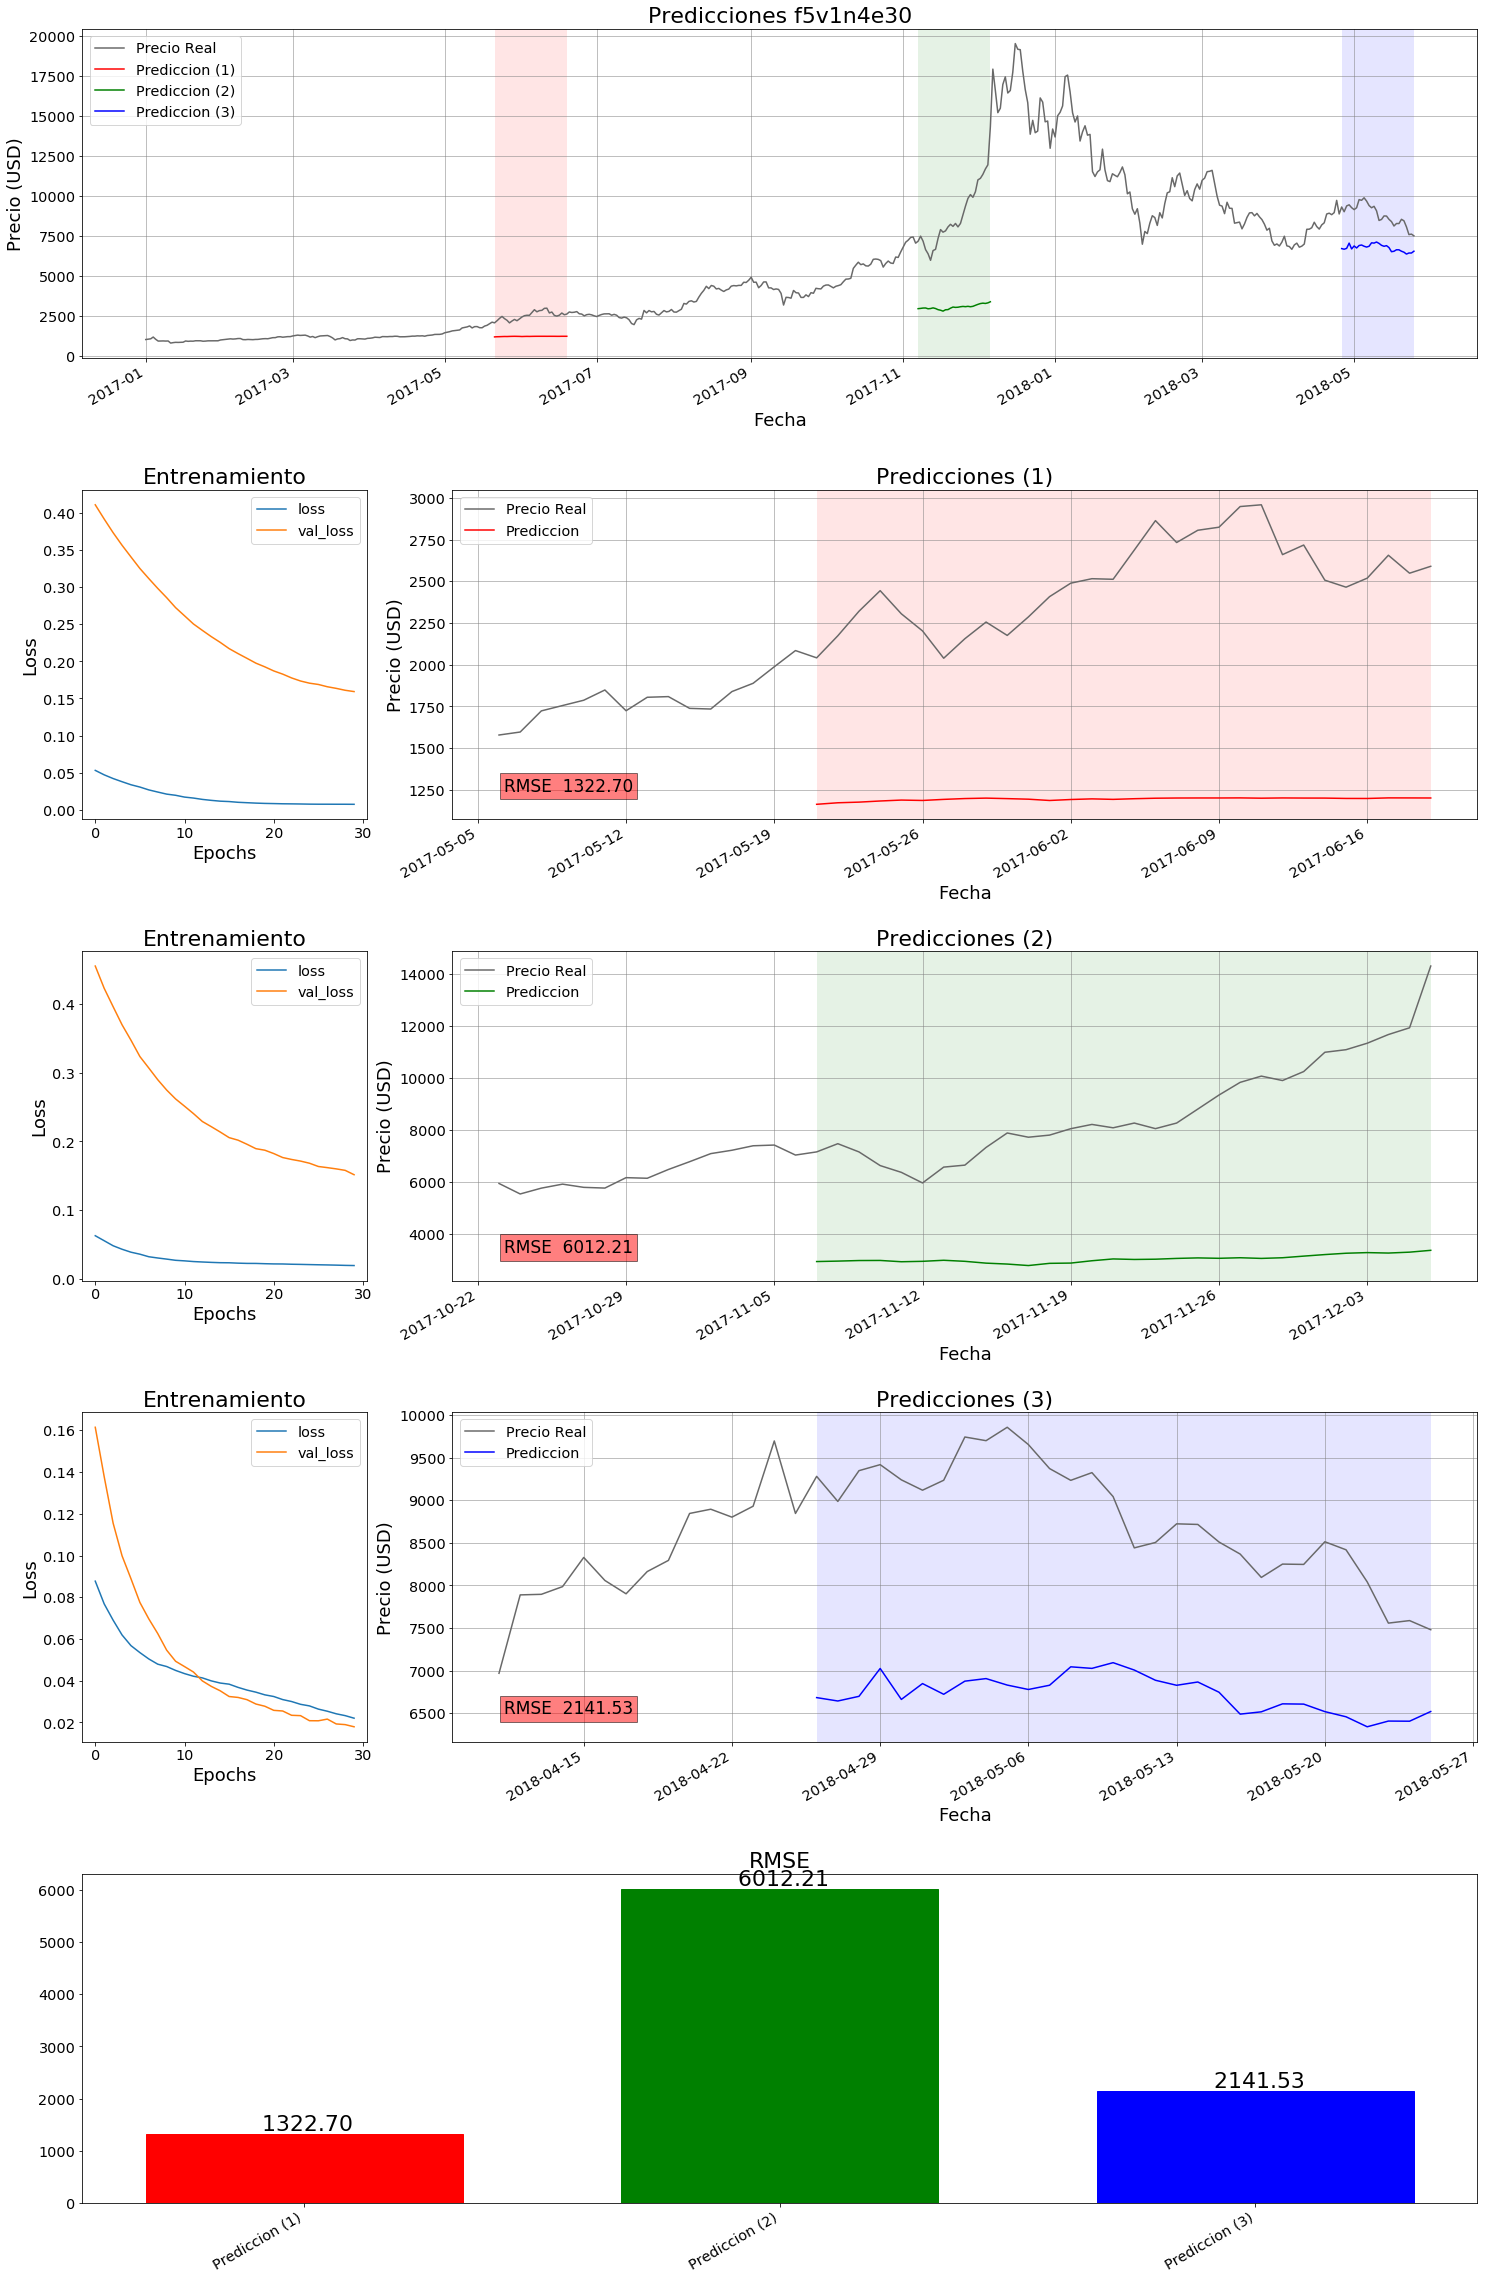

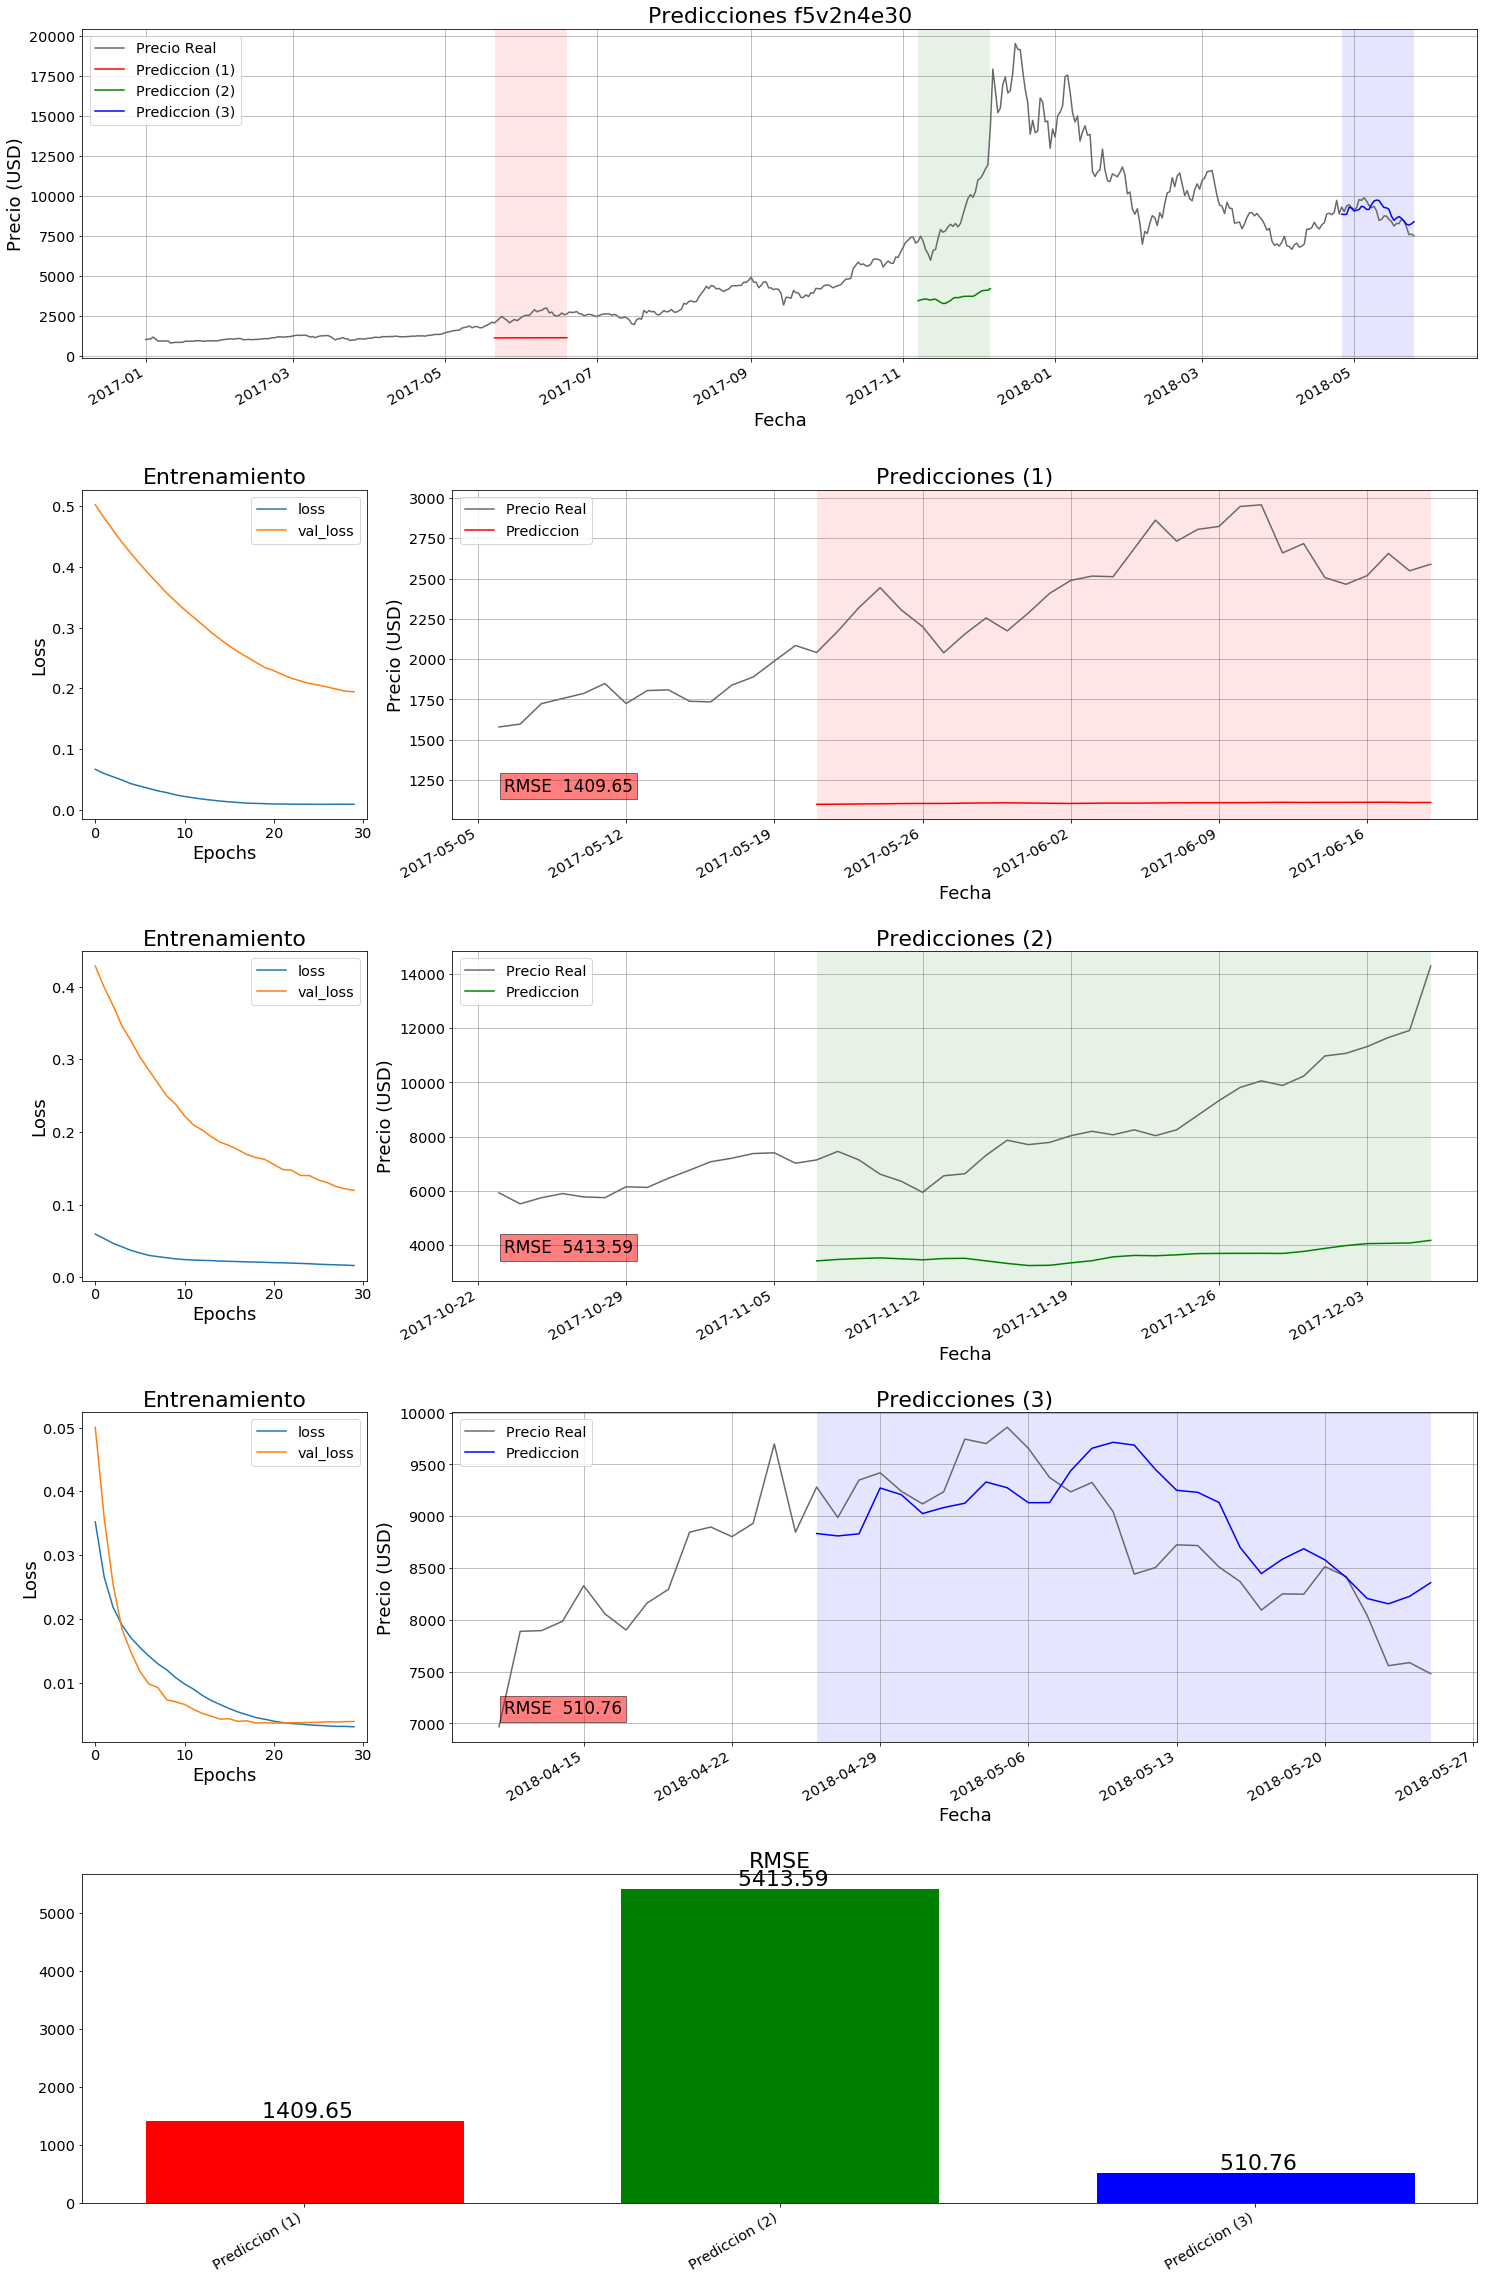

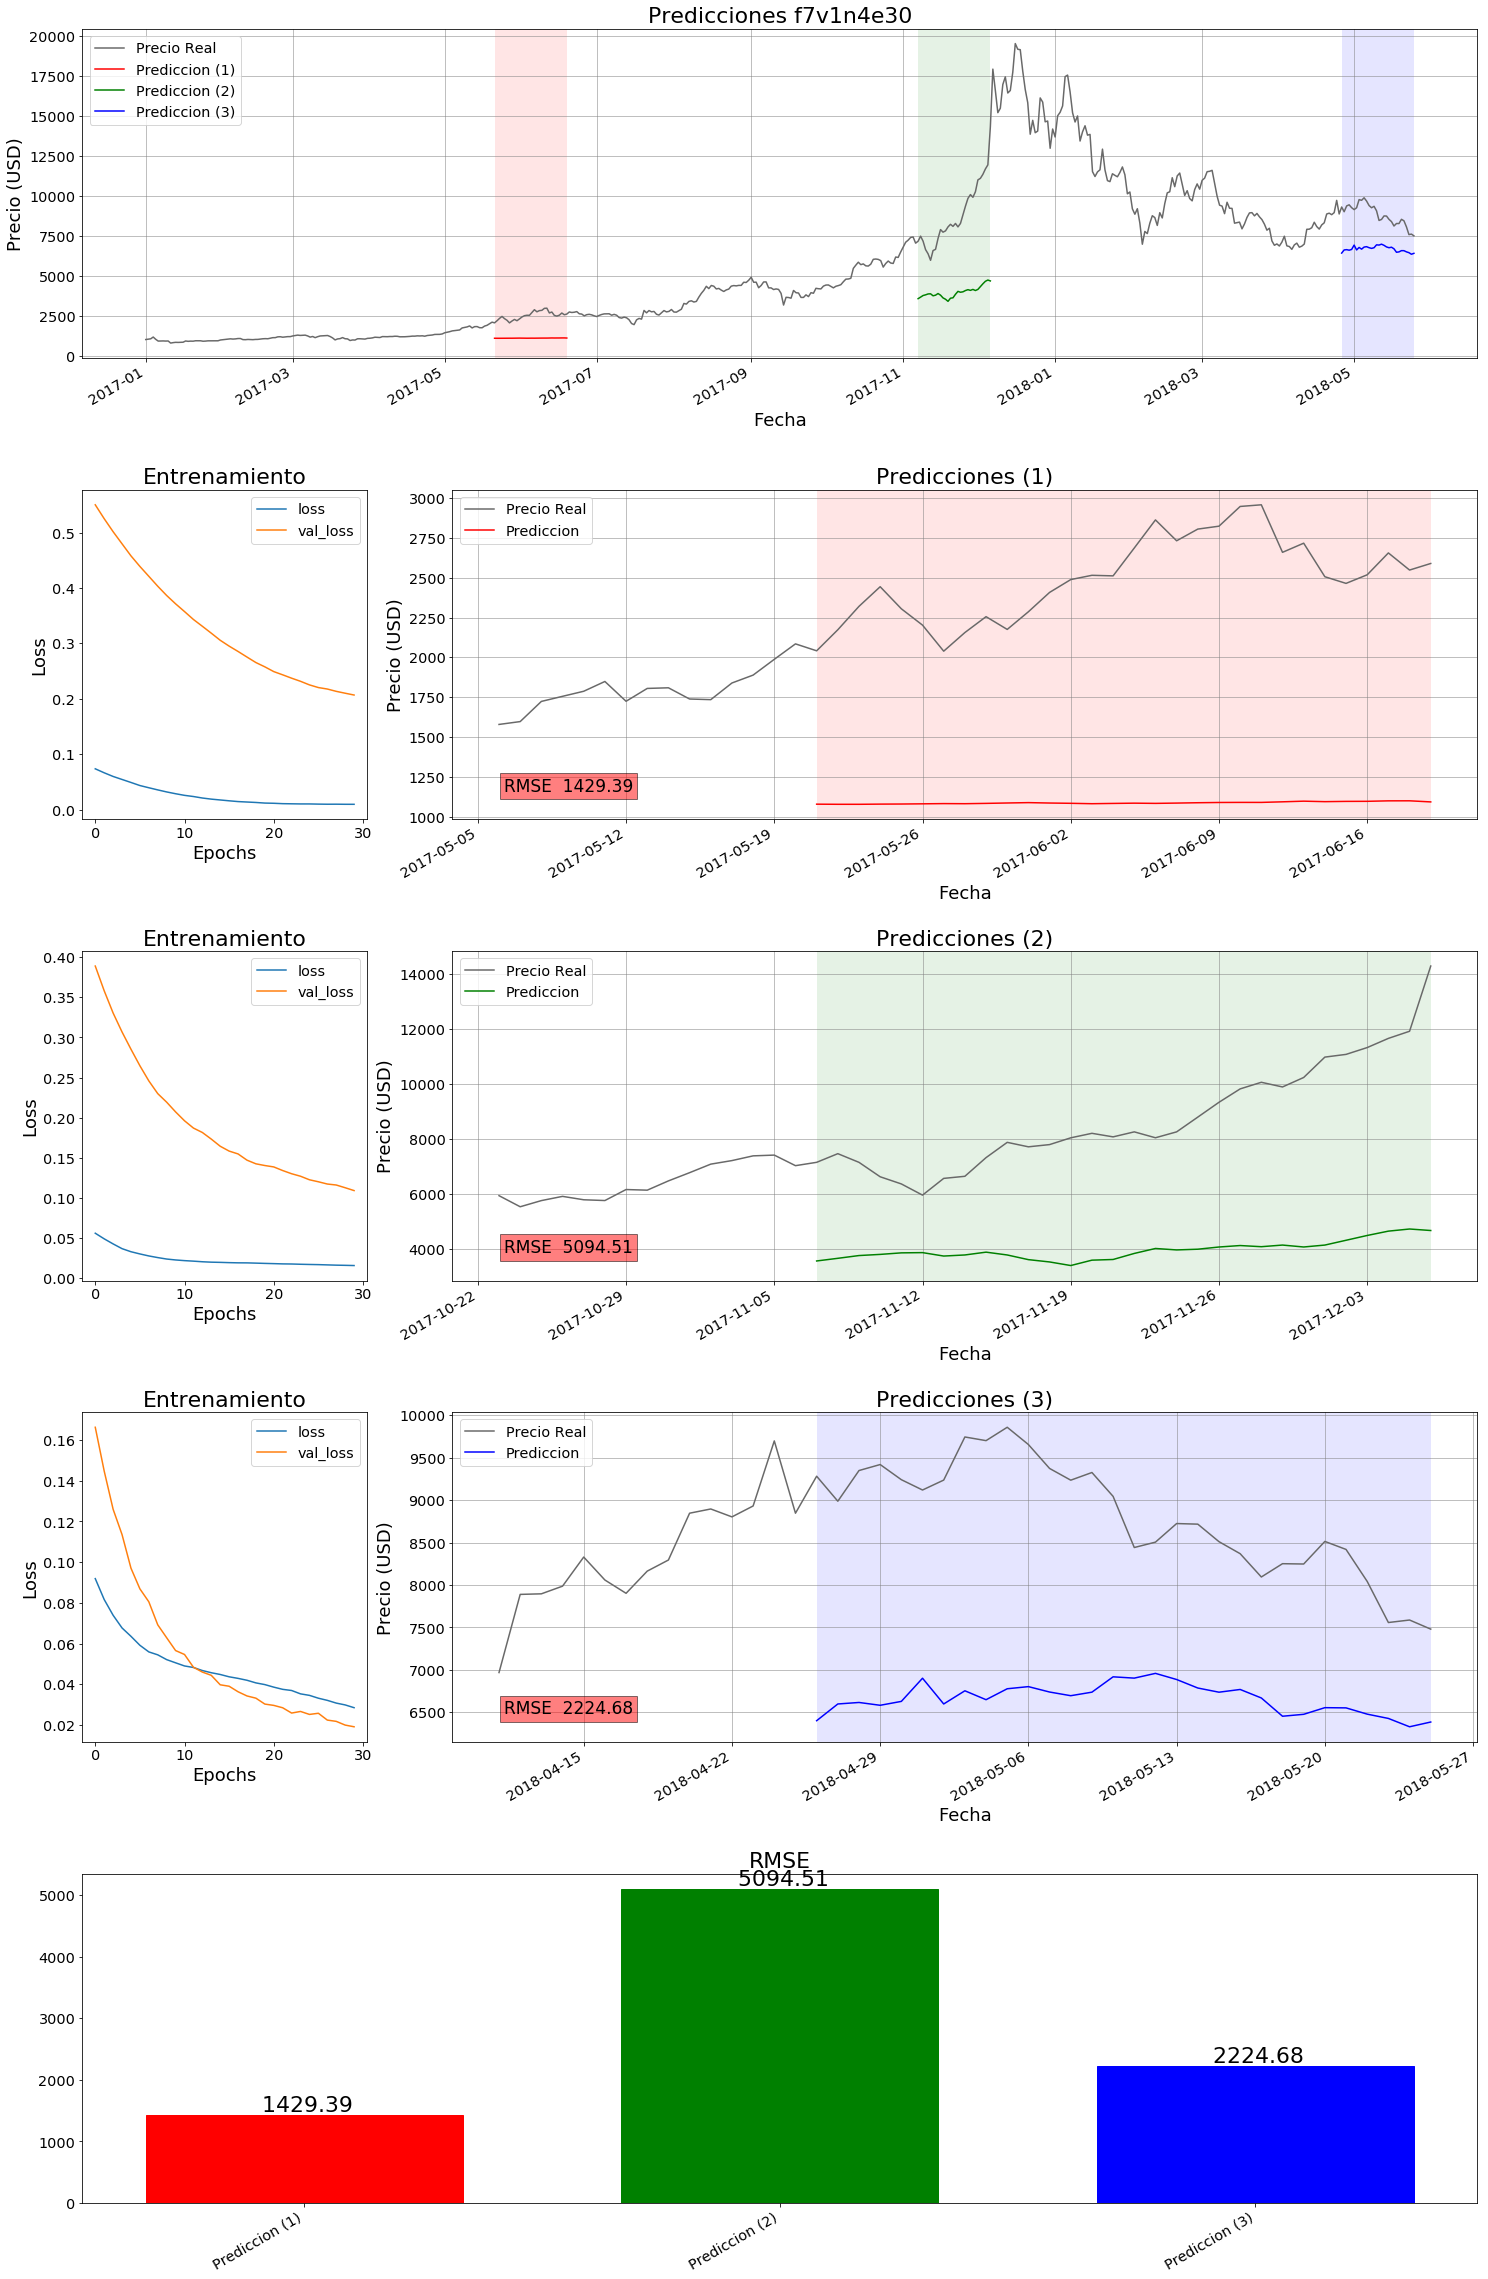

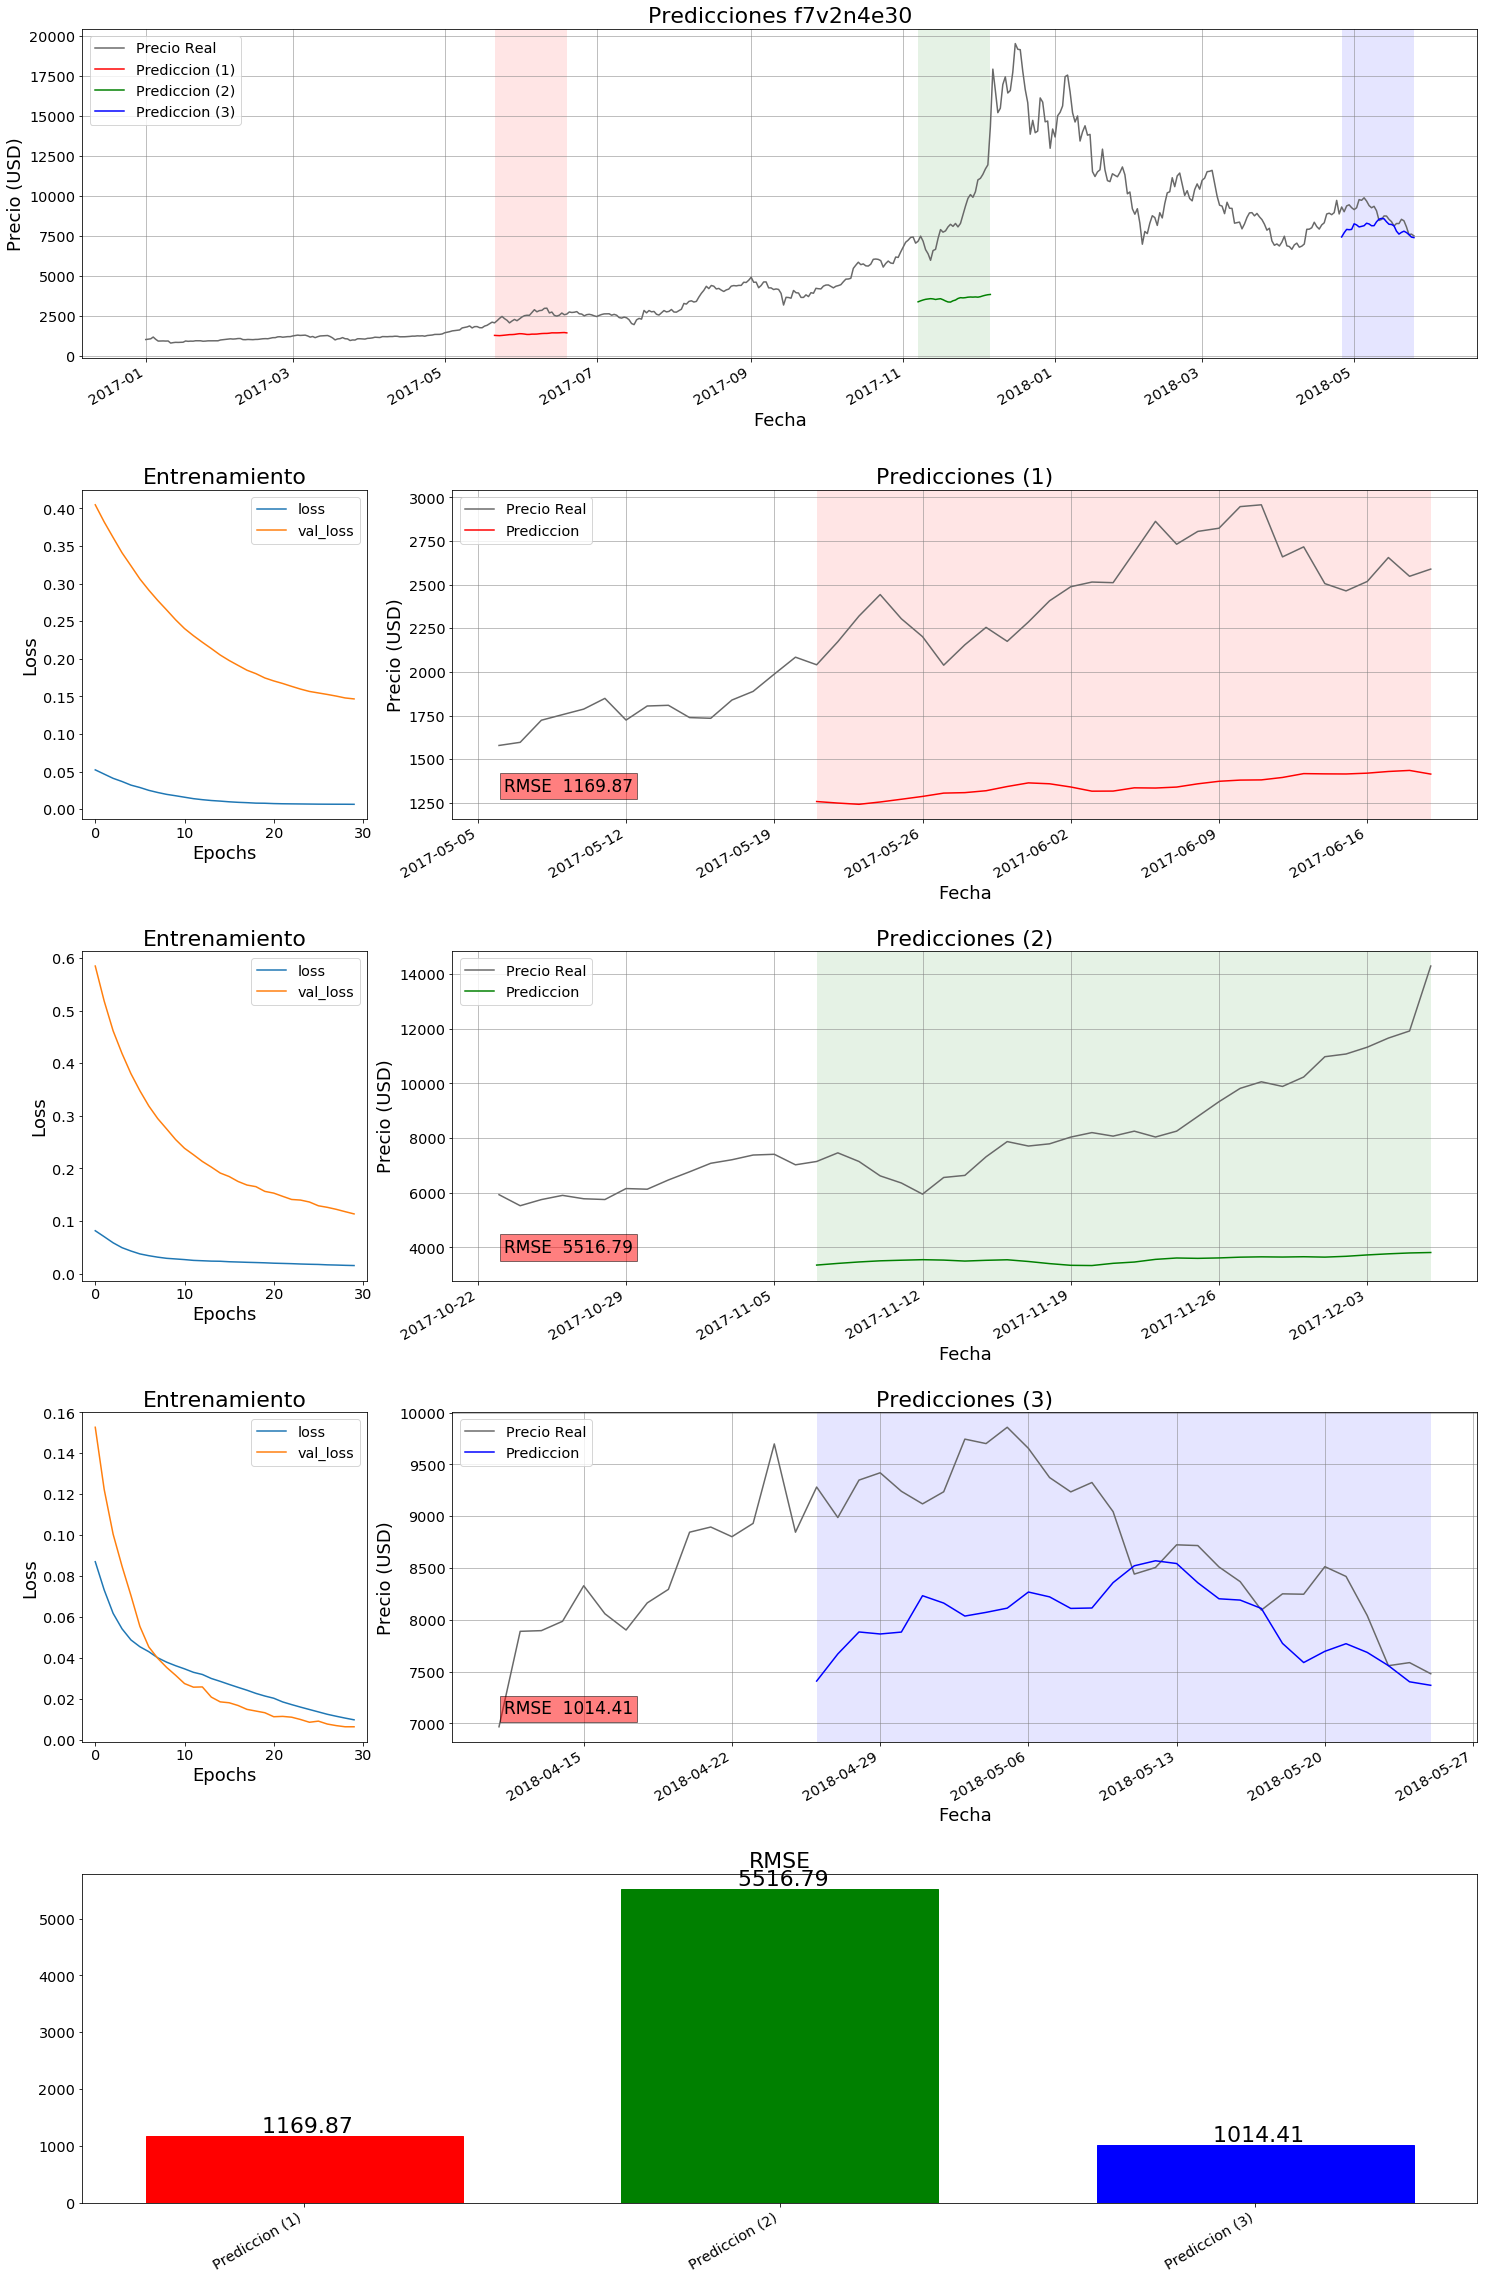

In [9]:
for f in futuro:
        for v in ventana:
            for n in neuronas:
                for e in epochs:    
                    dataset_name = 'f' + str(f) + 'v' + str(v) + 'n' + str(n) + 'e' + str(e)
                    datasetfolder = "predicciones" + "/"  + moneda + "/"+ dataset_name
                    i = 1
                    rmses_y = []
                    rmses_x = []
                    
                    #Visualización de resultados
                    fig = plt.figure(figsize=(25,10*4))
                    gs = gridspec.GridSpec(5, 4, wspace=0.3, hspace=0.4)

                    #Todas las predicciones
                    axPrediccionCompleta = plt.subplot(gs[0, 0:])
                    axPrediccionCompleta.plot(data.index, data[[moneda]], color='dimgray', label="Precio Real")  
                    axPrediccionCompleta.set_xlabel('Fecha', fontsize=18)
                    axPrediccionCompleta.set_ylabel('Precio (USD)', fontsize=18)
                    plt.xticks(rotation=30, ha="right")
                    axPrediccionCompleta.set_title("Predicciones " + dataset_name,fontsize=22)
                    axPrediccionCompleta.grid(color='grey', linestyle='-', linewidth=0.5) 
                    
                    for n_test in range(0,N_tests):
                        start = int(n_test*len(data)/N_tests)
                        end = int((n_test+1)*len(data)/N_tests)                            
                        prediccion = pd.read_csv(datasetfolder + '/predicciones_'+ dataset_name + '(' + str(n_test+1) + ')' +'.csv')
                        prediccion['Date'] = pd.to_datetime(prediccion['Date'])
                        prediccion.set_index('Date', inplace=True)
                        
                        #Porción de test de la predicción
                        prediccion_test = prediccion[-test_size:]

                        #Graficar la serie completa
                        axPrediccionCompleta.plot(prediccion_test[prediccion_test.columns[1]].index, prediccion_test[prediccion_test.columns[1]], color=colores_test[n_test], label='Prediccion (' + str(n_test+1) + ')')
                        axPrediccionCompleta.axvspan(prediccion_test.index[0], prediccion_test.index[-1], facecolor=colores_test[n_test], alpha=0.1)  
                        axPrediccionCompleta.legend(loc='upper left')                        
                                                
                        #Cada entrenamiento
                        entrenamiento = pd.read_csv(datasetfolder + '/entrenamiento_' + dataset_name + '('+ str(n_test+1) +').csv',index_col =0)
                        axTraining = plt.subplot(gs[i, 0])
                        axTraining.plot(entrenamiento[entrenamiento.columns[0]], label='loss')
                        axTraining.plot(entrenamiento[entrenamiento.columns[1]], label='val_loss')
                        axTraining.set_xlabel('Epochs', fontsize=18)
                        axTraining.set_ylabel('Loss', fontsize=18)
                        axTraining.legend(loc='upper right')
                        axTraining.set_title("Entrenamiento", fontsize=22)
                        
                        #Cada prediccion   
                        axPrediccion = plt.subplot(gs[i, 1:])
                        axPrediccion.plot(prediccion[prediccion.columns[0]].index[-45:], prediccion[prediccion.columns[0]][-45:], color='dimgray', label="Precio Real")
                        axPrediccion.plot(prediccion_test[prediccion_test.columns[1]].index, prediccion_test[prediccion_test.columns[1]], color=colores_test[n_test], label="Prediccion")
                        axPrediccion.axvspan(prediccion_test.index[0], prediccion_test.index[-1], facecolor=colores_test[n_test], alpha=0.1)
                        axPrediccion.set_xlabel('Fecha', fontsize=18)
                        axPrediccion.set_ylabel('Precio (USD)', fontsize=18)
                        plt.xticks(rotation=30, ha="right")
                        axPrediccion.legend(loc='upper left')
                        axPrediccion.set_title("Predicciones (" + str(i) + ")",fontsize=22)
                        axPrediccion.grid(color='grey', linestyle='-', linewidth=0.5) 
                        #RMSE
                        rmse = sqrt(mean_squared_error(prediccion_test[prediccion_test.columns[0]], prediccion_test[prediccion_test.columns[1]]))
                        axPrediccion.text(0.05, 0.1, 'RMSE ' + str('% 6.2f' % rmse), 
                                            horizontalalignment='left',verticalalignment='center', 
                                            transform=axPrediccion.transAxes, fontsize=17, bbox=dict(facecolor='red', alpha=0.5))
                        rmses_y.append(rmse)
                        rmses_x.append('Prediccion ('+ str(i) +')')  

                        i+=1

                    #RMSE
                    width = 1/1.5
                    barplot = plt.subplot(gs[-1, :])
                    barplot = plt.bar(rmses_x, rmses_y, width)
                    col = 0;
                    for rect in barplot: # Valores en las barras
                        height = rect.get_height()
                        plt.text(rect.get_x() + rect.get_width()/2.0, height, '% 6.2f' % height,fontsize=22, ha='center',va='bottom')
                        rect.set_color(colores_test[col]); col+=1
                    plt.xticks(rotation=30, ha="right")
                    plt.title("RMSE", fontsize=22)

                    plt.savefig(datasetfolder + "_predicciones.png", bbox_inches='tight')

In [10]:
#Método para graficar las predicciones
def graficarTop(predicciones,nombre):
    #Visualización de resultados
    fig = plt.figure(figsize=(25,10*4))
    gs = gridspec.GridSpec(5, 4, wspace=0.3, hspace=0.4)

    # Graficar la predicción completa (todos los subconjuntos de test)
    axPrediccionCompleta = plt.subplot(gs[0, 0:])
    axPrediccionCompleta.plot(predicciones.index, predicciones[predicciones.columns[0]], color='dimgray', label="Precio Real")  
    axPrediccionCompleta.set_xlabel('Fecha', fontsize=18)
    axPrediccionCompleta.set_ylabel('Precio (USD)', fontsize=18)
    plt.xticks(rotation=30, ha="right")
    axPrediccionCompleta.set_title("Predicciones - Método " + nombre, fontsize=22)
    axPrediccionCompleta.grid(color='grey', linestyle='-', linewidth=0.5) 
    col=0
    for c in predicciones.columns[1:]:
        #Graficar cada prediccion
        axPrediccionCompleta.plot(predicciones.index, predicciones[c], label=c, color=colores_futuro[col])   
        col+=1
    axPrediccionCompleta.legend(loc='upper left')  

    # Graficar cada subconjunto de test
    i=1 #index de subplot
    rmses_y = []
    rmses_x = []
    for n_test in range(0,N_tests): 
        end = int((n_test+1)*len(predicciones)/N_tests)
        subprediccion = predicciones[0:end]
        subprediccion_test = subprediccion[-test_size:]

        #Colorear cada porcion de testing
        axPrediccionCompleta.axvspan(subprediccion_test.index[0], subprediccion_test.index[-1], facecolor=colores_test[n_test], alpha=0.1)  

        #Cada prediccion   
        axPrediccion = plt.subplot(gs[i, 1:])
        axPrediccion.plot(subprediccion[subprediccion.columns[0]].index[-45:], subprediccion[subprediccion.columns[0]][-45:], color='dimgray', label="Precio Real")
        axPrediccion.axvspan(subprediccion_test.index[0], subprediccion_test.index[-1], facecolor=colores_test[n_test], alpha=0.1)
        axPrediccion.set_xlabel('Fecha', fontsize=18)
        axPrediccion.set_ylabel('Precio (USD)', fontsize=18)
        plt.xticks(rotation=30, ha="right")
        axPrediccion.set_title("Predicciones (" + str(i) + ")",fontsize=22)
        axPrediccion.grid(color='grey', linestyle='-', linewidth=0.5) 

        rmses_y_subprediccion = []
        rmses_x_subprediccion = []
        col=0 #color de futuro
        for c in subprediccion_test.columns[1:]:
            axPrediccion.plot(subprediccion_test[c].index, subprediccion_test[c], label=c, color=colores_futuro[col]);col+=1

            rmse = sqrt(mean_squared_error(subprediccion_test[subprediccion_test.columns[0]], 
                                           subprediccion_test[c]))
            rmses_y_subprediccion.append(rmse)        
            rmses_y.append(rmse)
            rmses_x.append(c +'('+ str(i) +')')  
            rmses_x_subprediccion.append(c +'('+ str(i) +')')  

        axPrediccion.legend(loc='upper left')

        #RMSE
        width = 1/1.5
        barplot = plt.subplot(gs[i, 0])
        barplot = plt.bar(rmses_x_subprediccion, rmses_y_subprediccion, width)
        col = 0
        for rect in barplot: # Valores en las barras
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2.0, height, '% 6.2f' % height,fontsize=22, ha='center',va='bottom')
            rect.set_color(colores_futuro[col]); col+=1
        plt.xticks(rotation=30, ha="right")
        plt.title("RMSE", fontsize=22)

        i+=1

    #Graficar todos los RMSE
    width = 1/1.5
    barplot = plt.subplot(gs[i, : ])
    bars = plt.bar(rmses_x, rmses_y, width)
    for n_test in range(0,N_tests):
        col = 0;
        for rect in bars[n_test*len(predicciones.columns[1:]) : (n_test+1)*len(predicciones.columns[1:])]: # Valores en las barras
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2.0, height, '% 6.2f' % height,fontsize=22, ha='center',va='bottom')
            rect.set_color(colores_futuro[col]); col+=1
            barplot.axvspan(rect.get_x(),rect.get_x()+rect.get_width(),facecolor=colores_test[n_test], alpha=0.1)
    plt.xticks(rotation=20)
    plt.title("RMSE "+ nombre,fontsize=20)

    plt.savefig("predicciones/"+moneda+"/TopRMSE.png", bbox_inches='tight')

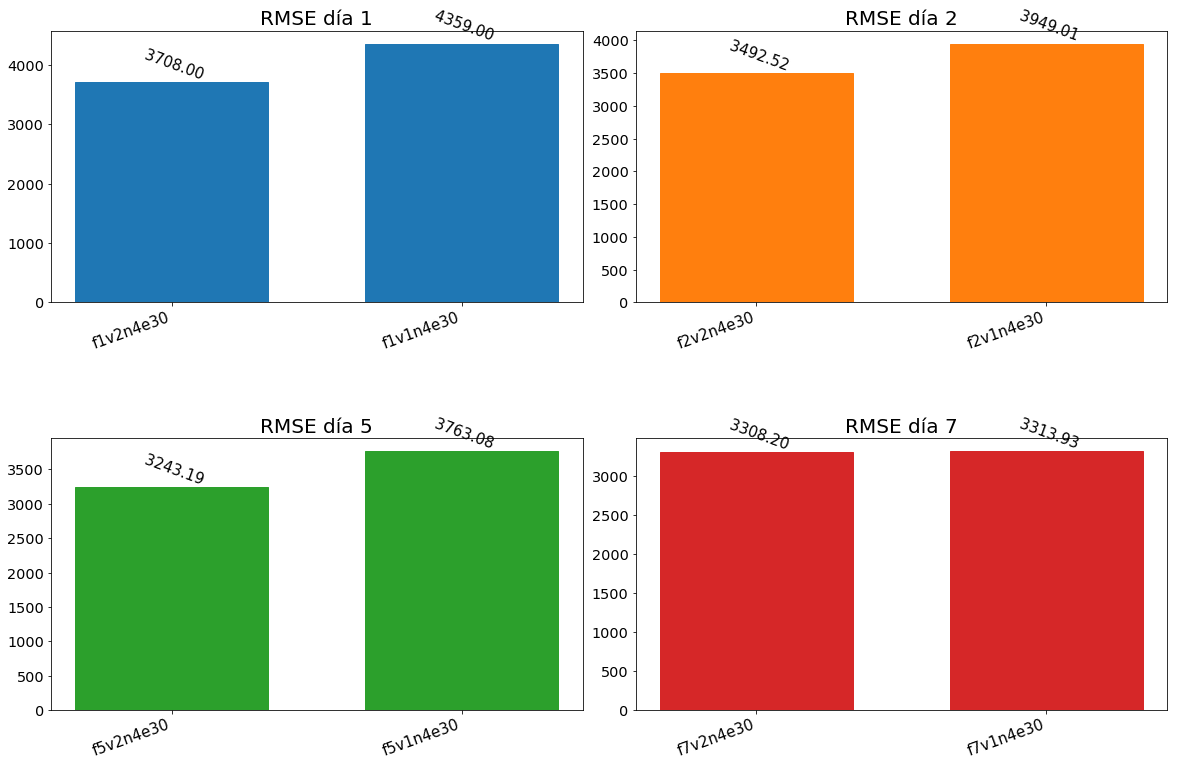

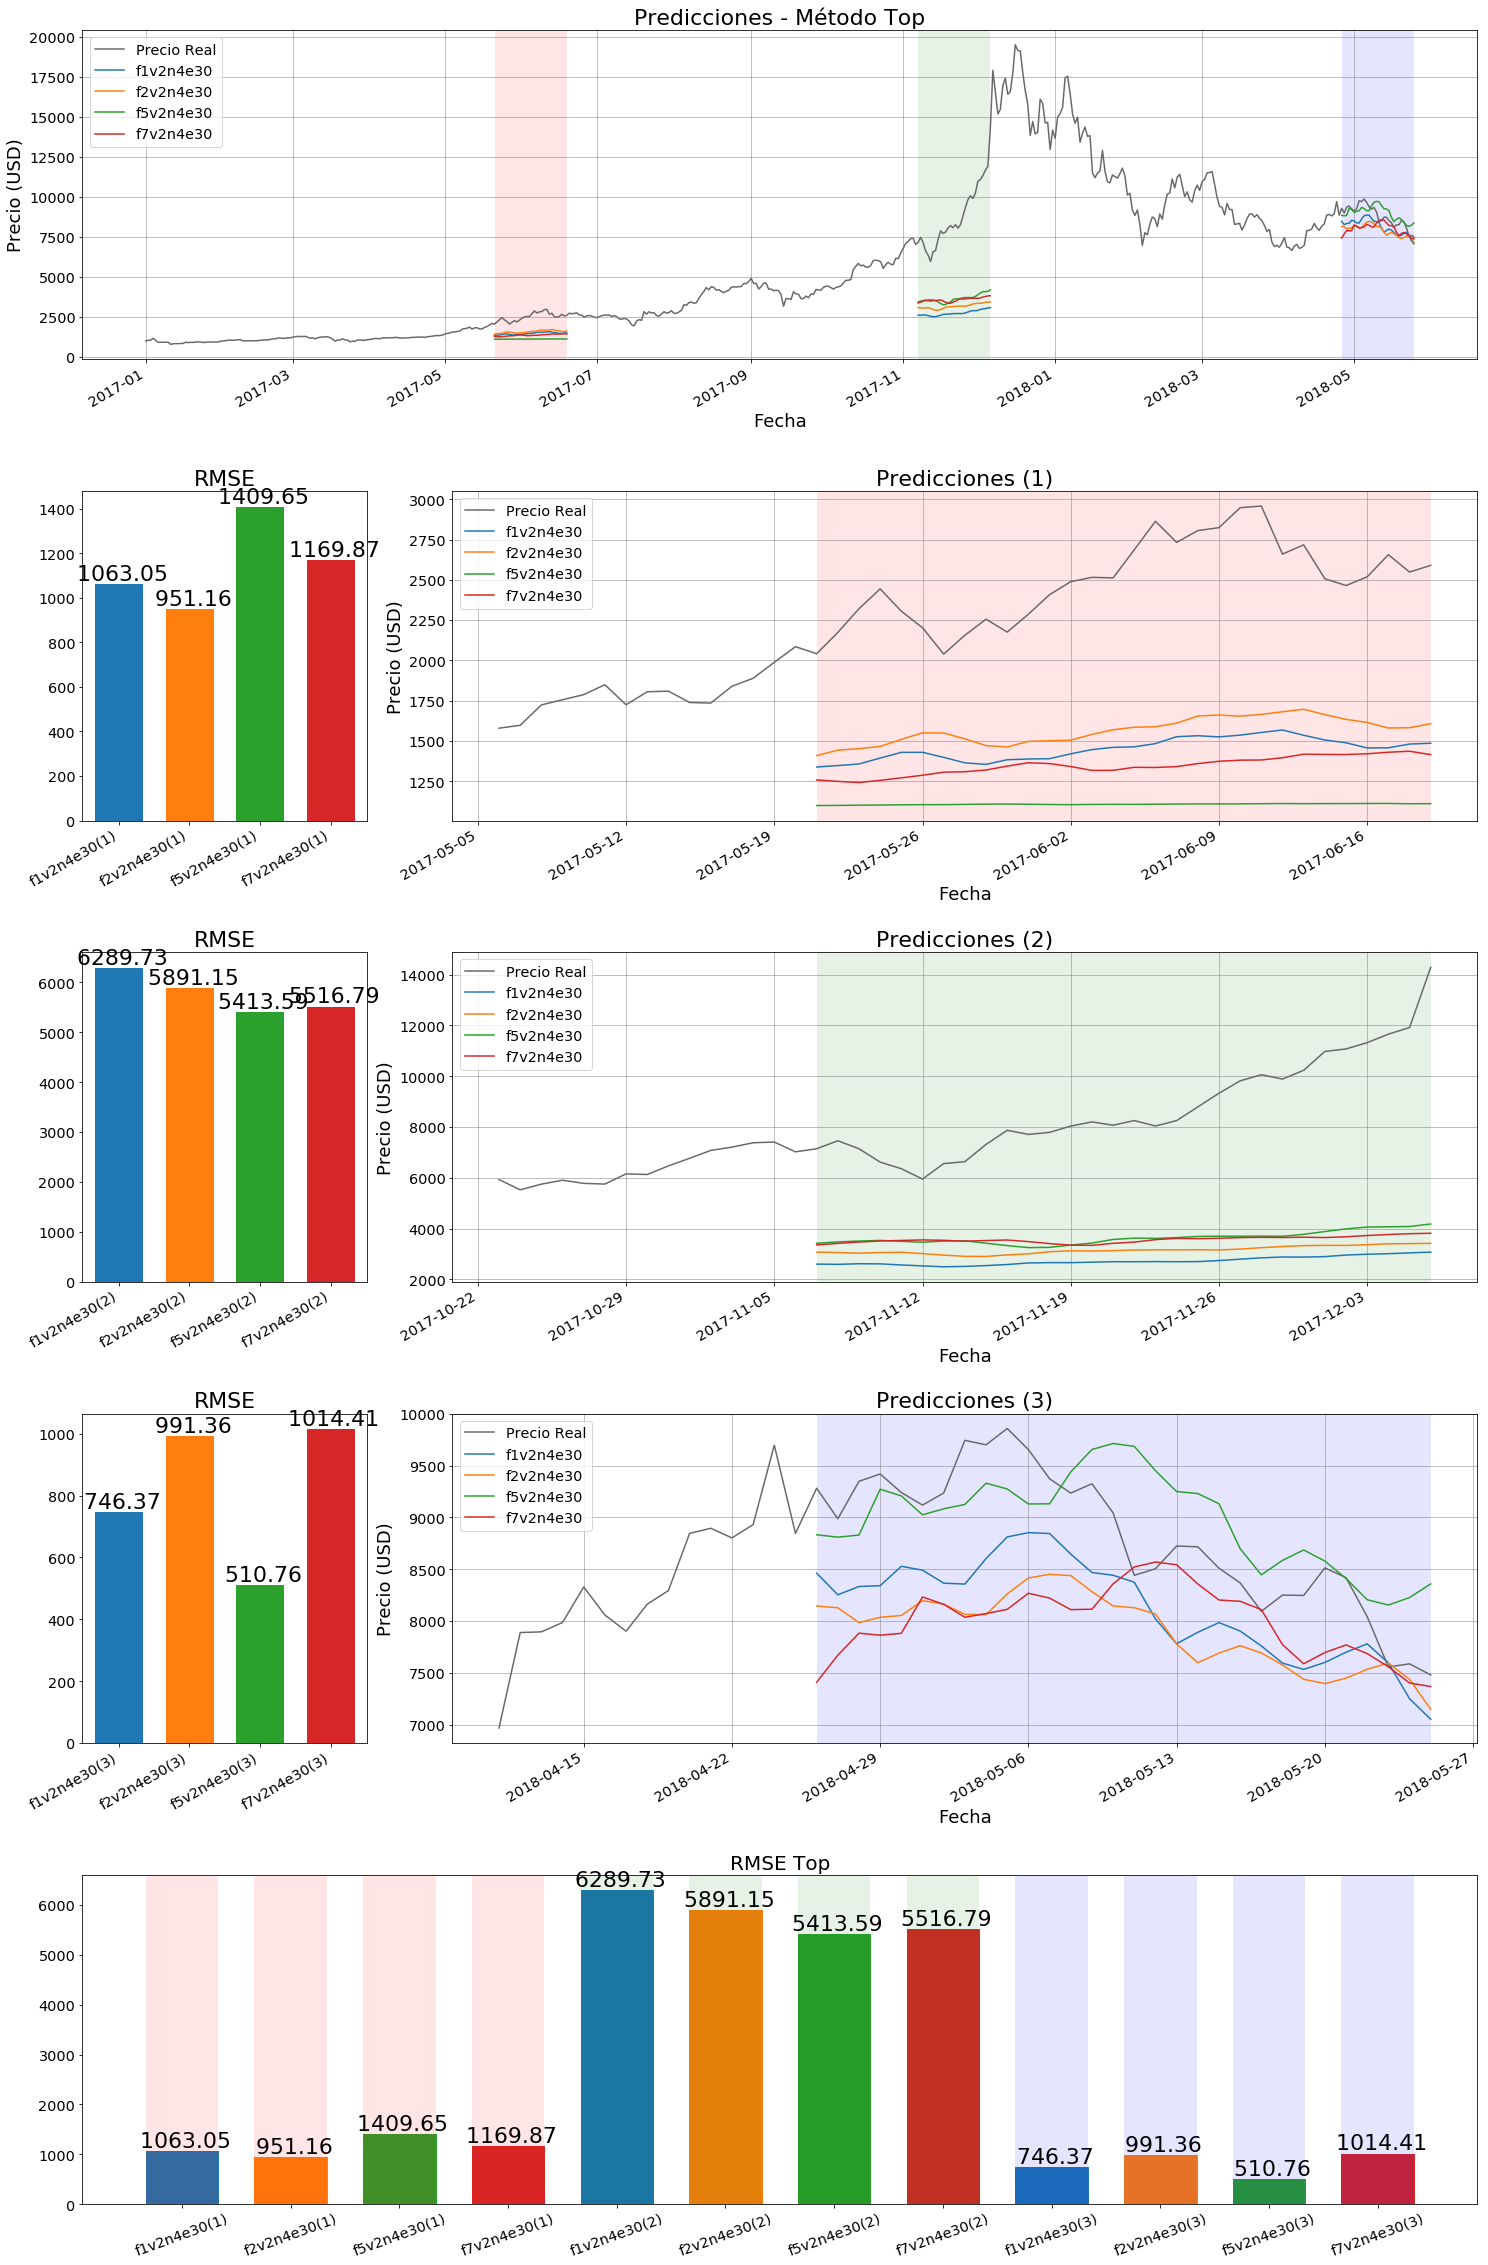

In [11]:
# Mostrar los mejores resultados para cada dia futuro
todaspredicciones = data.copy()[[moneda]]
rmses = [[] for i in range(0,len(futuro))]
rmse_i =  0
for f in futuro:
        prediccionxfuturo = pd.DataFrame()
        for v in ventana:
            for n in neuronas:
                for e in epochs:    
                    dataset_name = 'f' + str(f) + 'v' + str(v) + 'n' + str(n) + 'e' + str(e)
                    datasetfolder = "predicciones" + "/"  + moneda + "/"+ dataset_name
                    #Obtengo un dataframe con las predicciones de un método para todos los días y todos los subconjuntos de tests
                    prediccionxdataset = pd.DataFrame()
                    for n_test in range(0,N_tests):     
                        prediccion = pd.read_csv(datasetfolder + '/predicciones_'+ dataset_name + '(' + str(n_test+1) + ')' +'.csv')
                        prediccion['Date'] = pd.to_datetime(prediccion['Date'])
                        prediccion.set_index('Date', inplace=True)
                        prediccion = prediccion[-test_size:].rename(columns={prediccion.columns[1]: dataset_name})
                        prediccionxdataset = prediccionxdataset.append(prediccion)                    
                    prediccionxfuturo = pd.concat([prediccionxfuturo, prediccionxdataset.drop(columns=[moneda])], axis=1)
        #En prediccionxfuturo tengo las predicciones de los tres subsets (sin NaN), sin columna de bitcoin, para todos los datasets de f
        # Obtengo un dataframe con todas las predicciones (con NaNs)
        todaspredicciones = pd.merge(todaspredicciones,prediccionxfuturo, how="left",left_index=True,right_index=True)
        #Agrego la columna de bitcoin como última columna del dataframe
        prediccionxfuturo = pd.merge(prediccionxfuturo,data.copy()[[moneda]],how='left',left_index=True,right_index=True)
        
        # Calculo los RMSE para cada día (toma los tres subconjuntos de tests al mismo tiempo)
        for pred_f in range(0,len(prediccionxfuturo.columns[:-1])):
            rmse = sqrt(mean_squared_error(prediccionxfuturo[prediccionxfuturo.columns[-1]], 
                                           prediccionxfuturo[prediccionxfuturo.columns[pred_f]]))
            rmses[rmse_i].append([prediccionxfuturo.columns[pred_f],rmse])
        rmse_i+=1

# En el arreglo 'rmses' tengo cada los RMSE ordenados por dia futuro [ [rmses de dia 1], [rmses de día 2], ... ]
def getKey(rmse):
    return rmse[1]

top_columns = [moneda]

#Visualización de resultados
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(3, 2, wspace=0.1, hspace=0.5)
for i in range(0,len(futuro)):
    top_rmses = sorted(rmses[i], key=getKey)
    rmses_x = [rmse[0] for rmse in top_rmses]
    rmses_y = [rmse[1] for rmse in top_rmses]

    top_columns.append(rmses_x[0])
    
    width = 1/1.5
    barplot = plt.subplot(gs[i])
    bars = plt.bar(rmses_x, rmses_y, width)
    for rect in bars: # Valores en las barras
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2.0, height, '% 6.2f' % height,fontsize=15, ha='center',va='bottom',rotation=-20)
            rect.set_color(colores_futuro[i])
    plt.xticks(rotation=20, ha='right', fontsize=15)
    plt.title("RMSE día "+ str(futuro[i]),fontsize=20)
    plt.savefig("predicciones/"+moneda+"/RMSE.png", bbox_inches='tight')

graficarTop(todaspredicciones.filter(top_columns),"Top")